In [19]:
import matplotlib.pyplot as plt
from src.models import *
from src.model_analysis.utils import same_output
from src.post_quant.cle import cle_for_resmlp
from src.post_quant.bias_absorb import ba_for_resmlp
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels, get_linear_layers

org_model = resmlp_24(pretrained=False).eval()
org_model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
model = resmlp_24(pretrained=False).eval()
model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
print(same_output(model, org_model, eps=1e-5))

# model_norm = resmlp_24_norm(pretrained=False).eval()
# model_norm.load_state_dict(torch.load("771.pth")["model"])
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load("folder/resmlp-affine-cle/model_best.pth.tar")["state_dict"])

# # test CLE
# org_model = resmlp_24(pretrained=False).eval()
# org_model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# model = resmlp_24(pretrained=False).eval()
# model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# cle_for_resmlp(model)


True


RuntimeError: Error(s) in loading state_dict for Q_ResMLP24:
	Missing key(s) in state_dict: "quant_input.observer.calibrate_count", "quant_input.observer.counter", "quant_input.observer.scale", "quant_patch.proj.observer.calibrate_count", "quant_patch.proj.observer.counter", "quant_patch.proj.observer.scale", "quant_patch.act.observer.calibrate_count", "quant_patch.act.observer.counter", "quant_patch.act.observer.scale", "blocks.0.norm1.observer.calibrate_count", "blocks.0.norm1.observer.counter", "blocks.0.norm1.observer.scale", "blocks.0.act1.observer.calibrate_count", "blocks.0.act1.observer.counter", "blocks.0.act1.observer.scale", "blocks.0.attn.observer.calibrate_count", "blocks.0.attn.observer.counter", "blocks.0.attn.observer.scale", "blocks.0.act2.observer.calibrate_count", "blocks.0.act2.observer.counter", "blocks.0.act2.observer.scale", "blocks.0.gamma_1.observer.calibrate_count", "blocks.0.gamma_1.observer.counter", "blocks.0.gamma_1.observer.scale", "blocks.0.add_1.observer.calibrate_count", "blocks.0.add_1.observer.counter", "blocks.0.add_1.observer.scale", "blocks.0.norm2.observer.calibrate_count", "blocks.0.norm2.observer.counter", "blocks.0.norm2.observer.scale", "blocks.0.act3.observer.calibrate_count", "blocks.0.act3.observer.counter", "blocks.0.act3.observer.scale", "blocks.0.mlp.fc1.observer.calibrate_count", "blocks.0.mlp.fc1.observer.counter", "blocks.0.mlp.fc1.observer.scale", "blocks.0.mlp.act1.observer.calibrate_count", "blocks.0.mlp.act1.observer.counter", "blocks.0.mlp.act1.observer.scale", "blocks.0.mlp.fc2.observer.calibrate_count", "blocks.0.mlp.fc2.observer.counter", "blocks.0.mlp.fc2.observer.scale", "blocks.0.mlp.act2.observer.calibrate_count", "blocks.0.mlp.act2.observer.counter", "blocks.0.mlp.act2.observer.scale", "blocks.0.gamma_2.observer.calibrate_count", "blocks.0.gamma_2.observer.counter", "blocks.0.gamma_2.observer.scale", "blocks.0.add_2.observer.calibrate_count", "blocks.0.add_2.observer.counter", "blocks.0.add_2.observer.scale", "blocks.1.norm1.observer.calibrate_count", "blocks.1.norm1.observer.counter", "blocks.1.norm1.observer.scale", "blocks.1.act1.observer.calibrate_count", "blocks.1.act1.observer.counter", "blocks.1.act1.observer.scale", "blocks.1.attn.observer.calibrate_count", "blocks.1.attn.observer.counter", "blocks.1.attn.observer.scale", "blocks.1.act2.observer.calibrate_count", "blocks.1.act2.observer.counter", "blocks.1.act2.observer.scale", "blocks.1.gamma_1.observer.calibrate_count", "blocks.1.gamma_1.observer.counter", "blocks.1.gamma_1.observer.scale", "blocks.1.add_1.observer.calibrate_count", "blocks.1.add_1.observer.counter", "blocks.1.add_1.observer.scale", "blocks.1.norm2.observer.calibrate_count", "blocks.1.norm2.observer.counter", "blocks.1.norm2.observer.scale", "blocks.1.act3.observer.calibrate_count", "blocks.1.act3.observer.counter", "blocks.1.act3.observer.scale", "blocks.1.mlp.fc1.observer.calibrate_count", "blocks.1.mlp.fc1.observer.counter", "blocks.1.mlp.fc1.observer.scale", "blocks.1.mlp.act1.observer.calibrate_count", "blocks.1.mlp.act1.observer.counter", "blocks.1.mlp.act1.observer.scale", "blocks.1.mlp.fc2.observer.calibrate_count", "blocks.1.mlp.fc2.observer.counter", "blocks.1.mlp.fc2.observer.scale", "blocks.1.mlp.act2.observer.calibrate_count", "blocks.1.mlp.act2.observer.counter", "blocks.1.mlp.act2.observer.scale", "blocks.1.gamma_2.observer.calibrate_count", "blocks.1.gamma_2.observer.counter", "blocks.1.gamma_2.observer.scale", "blocks.1.add_2.observer.calibrate_count", "blocks.1.add_2.observer.counter", "blocks.1.add_2.observer.scale", "blocks.2.norm1.observer.calibrate_count", "blocks.2.norm1.observer.counter", "blocks.2.norm1.observer.scale", "blocks.2.act1.observer.calibrate_count", "blocks.2.act1.observer.counter", "blocks.2.act1.observer.scale", "blocks.2.attn.observer.calibrate_count", "blocks.2.attn.observer.counter", "blocks.2.attn.observer.scale", "blocks.2.act2.observer.calibrate_count", "blocks.2.act2.observer.counter", "blocks.2.act2.observer.scale", "blocks.2.gamma_1.observer.calibrate_count", "blocks.2.gamma_1.observer.counter", "blocks.2.gamma_1.observer.scale", "blocks.2.add_1.observer.calibrate_count", "blocks.2.add_1.observer.counter", "blocks.2.add_1.observer.scale", "blocks.2.norm2.observer.calibrate_count", "blocks.2.norm2.observer.counter", "blocks.2.norm2.observer.scale", "blocks.2.act3.observer.calibrate_count", "blocks.2.act3.observer.counter", "blocks.2.act3.observer.scale", "blocks.2.mlp.fc1.observer.calibrate_count", "blocks.2.mlp.fc1.observer.counter", "blocks.2.mlp.fc1.observer.scale", "blocks.2.mlp.act1.observer.calibrate_count", "blocks.2.mlp.act1.observer.counter", "blocks.2.mlp.act1.observer.scale", "blocks.2.mlp.fc2.observer.calibrate_count", "blocks.2.mlp.fc2.observer.counter", "blocks.2.mlp.fc2.observer.scale", "blocks.2.mlp.act2.observer.calibrate_count", "blocks.2.mlp.act2.observer.counter", "blocks.2.mlp.act2.observer.scale", "blocks.2.gamma_2.observer.calibrate_count", "blocks.2.gamma_2.observer.counter", "blocks.2.gamma_2.observer.scale", "blocks.2.add_2.observer.calibrate_count", "blocks.2.add_2.observer.counter", "blocks.2.add_2.observer.scale", "blocks.3.norm1.observer.calibrate_count", "blocks.3.norm1.observer.counter", "blocks.3.norm1.observer.scale", "blocks.3.act1.observer.calibrate_count", "blocks.3.act1.observer.counter", "blocks.3.act1.observer.scale", "blocks.3.attn.observer.calibrate_count", "blocks.3.attn.observer.counter", "blocks.3.attn.observer.scale", "blocks.3.act2.observer.calibrate_count", "blocks.3.act2.observer.counter", "blocks.3.act2.observer.scale", "blocks.3.gamma_1.observer.calibrate_count", "blocks.3.gamma_1.observer.counter", "blocks.3.gamma_1.observer.scale", "blocks.3.add_1.observer.calibrate_count", "blocks.3.add_1.observer.counter", "blocks.3.add_1.observer.scale", "blocks.3.norm2.observer.calibrate_count", "blocks.3.norm2.observer.counter", "blocks.3.norm2.observer.scale", "blocks.3.act3.observer.calibrate_count", "blocks.3.act3.observer.counter", "blocks.3.act3.observer.scale", "blocks.3.mlp.fc1.observer.calibrate_count", "blocks.3.mlp.fc1.observer.counter", "blocks.3.mlp.fc1.observer.scale", "blocks.3.mlp.act1.observer.calibrate_count", "blocks.3.mlp.act1.observer.counter", "blocks.3.mlp.act1.observer.scale", "blocks.3.mlp.fc2.observer.calibrate_count", "blocks.3.mlp.fc2.observer.counter", "blocks.3.mlp.fc2.observer.scale", "blocks.3.mlp.act2.observer.calibrate_count", "blocks.3.mlp.act2.observer.counter", "blocks.3.mlp.act2.observer.scale", "blocks.3.gamma_2.observer.calibrate_count", "blocks.3.gamma_2.observer.counter", "blocks.3.gamma_2.observer.scale", "blocks.3.add_2.observer.calibrate_count", "blocks.3.add_2.observer.counter", "blocks.3.add_2.observer.scale", "blocks.4.norm1.observer.calibrate_count", "blocks.4.norm1.observer.counter", "blocks.4.norm1.observer.scale", "blocks.4.act1.observer.calibrate_count", "blocks.4.act1.observer.counter", "blocks.4.act1.observer.scale", "blocks.4.attn.observer.calibrate_count", "blocks.4.attn.observer.counter", "blocks.4.attn.observer.scale", "blocks.4.act2.observer.calibrate_count", "blocks.4.act2.observer.counter", "blocks.4.act2.observer.scale", "blocks.4.gamma_1.observer.calibrate_count", "blocks.4.gamma_1.observer.counter", "blocks.4.gamma_1.observer.scale", "blocks.4.add_1.observer.calibrate_count", "blocks.4.add_1.observer.counter", "blocks.4.add_1.observer.scale", "blocks.4.norm2.observer.calibrate_count", "blocks.4.norm2.observer.counter", "blocks.4.norm2.observer.scale", "blocks.4.act3.observer.calibrate_count", "blocks.4.act3.observer.counter", "blocks.4.act3.observer.scale", "blocks.4.mlp.fc1.observer.calibrate_count", "blocks.4.mlp.fc1.observer.counter", "blocks.4.mlp.fc1.observer.scale", "blocks.4.mlp.act1.observer.calibrate_count", "blocks.4.mlp.act1.observer.counter", "blocks.4.mlp.act1.observer.scale", "blocks.4.mlp.fc2.observer.calibrate_count", "blocks.4.mlp.fc2.observer.counter", "blocks.4.mlp.fc2.observer.scale", "blocks.4.mlp.act2.observer.calibrate_count", "blocks.4.mlp.act2.observer.counter", "blocks.4.mlp.act2.observer.scale", "blocks.4.gamma_2.observer.calibrate_count", "blocks.4.gamma_2.observer.counter", "blocks.4.gamma_2.observer.scale", "blocks.4.add_2.observer.calibrate_count", "blocks.4.add_2.observer.counter", "blocks.4.add_2.observer.scale", "blocks.5.norm1.observer.calibrate_count", "blocks.5.norm1.observer.counter", "blocks.5.norm1.observer.scale", "blocks.5.act1.observer.calibrate_count", "blocks.5.act1.observer.counter", "blocks.5.act1.observer.scale", "blocks.5.attn.observer.calibrate_count", "blocks.5.attn.observer.counter", "blocks.5.attn.observer.scale", "blocks.5.act2.observer.calibrate_count", "blocks.5.act2.observer.counter", "blocks.5.act2.observer.scale", "blocks.5.gamma_1.observer.calibrate_count", "blocks.5.gamma_1.observer.counter", "blocks.5.gamma_1.observer.scale", "blocks.5.add_1.observer.calibrate_count", "blocks.5.add_1.observer.counter", "blocks.5.add_1.observer.scale", "blocks.5.norm2.observer.calibrate_count", "blocks.5.norm2.observer.counter", "blocks.5.norm2.observer.scale", "blocks.5.act3.observer.calibrate_count", "blocks.5.act3.observer.counter", "blocks.5.act3.observer.scale", "blocks.5.mlp.fc1.observer.calibrate_count", "blocks.5.mlp.fc1.observer.counter", "blocks.5.mlp.fc1.observer.scale", "blocks.5.mlp.act1.observer.calibrate_count", "blocks.5.mlp.act1.observer.counter", "blocks.5.mlp.act1.observer.scale", "blocks.5.mlp.fc2.observer.calibrate_count", "blocks.5.mlp.fc2.observer.counter", "blocks.5.mlp.fc2.observer.scale", "blocks.5.mlp.act2.observer.calibrate_count", "blocks.5.mlp.act2.observer.counter", "blocks.5.mlp.act2.observer.scale", "blocks.5.gamma_2.observer.calibrate_count", "blocks.5.gamma_2.observer.counter", "blocks.5.gamma_2.observer.scale", "blocks.5.add_2.observer.calibrate_count", "blocks.5.add_2.observer.counter", "blocks.5.add_2.observer.scale", "blocks.6.norm1.observer.calibrate_count", "blocks.6.norm1.observer.counter", "blocks.6.norm1.observer.scale", "blocks.6.act1.observer.calibrate_count", "blocks.6.act1.observer.counter", "blocks.6.act1.observer.scale", "blocks.6.attn.observer.calibrate_count", "blocks.6.attn.observer.counter", "blocks.6.attn.observer.scale", "blocks.6.act2.observer.calibrate_count", "blocks.6.act2.observer.counter", "blocks.6.act2.observer.scale", "blocks.6.gamma_1.observer.calibrate_count", "blocks.6.gamma_1.observer.counter", "blocks.6.gamma_1.observer.scale", "blocks.6.add_1.observer.calibrate_count", "blocks.6.add_1.observer.counter", "blocks.6.add_1.observer.scale", "blocks.6.norm2.observer.calibrate_count", "blocks.6.norm2.observer.counter", "blocks.6.norm2.observer.scale", "blocks.6.act3.observer.calibrate_count", "blocks.6.act3.observer.counter", "blocks.6.act3.observer.scale", "blocks.6.mlp.fc1.observer.calibrate_count", "blocks.6.mlp.fc1.observer.counter", "blocks.6.mlp.fc1.observer.scale", "blocks.6.mlp.act1.observer.calibrate_count", "blocks.6.mlp.act1.observer.counter", "blocks.6.mlp.act1.observer.scale", "blocks.6.mlp.fc2.observer.calibrate_count", "blocks.6.mlp.fc2.observer.counter", "blocks.6.mlp.fc2.observer.scale", "blocks.6.mlp.act2.observer.calibrate_count", "blocks.6.mlp.act2.observer.counter", "blocks.6.mlp.act2.observer.scale", "blocks.6.gamma_2.observer.calibrate_count", "blocks.6.gamma_2.observer.counter", "blocks.6.gamma_2.observer.scale", "blocks.6.add_2.observer.calibrate_count", "blocks.6.add_2.observer.counter", "blocks.6.add_2.observer.scale", "blocks.7.norm1.observer.calibrate_count", "blocks.7.norm1.observer.counter", "blocks.7.norm1.observer.scale", "blocks.7.act1.observer.calibrate_count", "blocks.7.act1.observer.counter", "blocks.7.act1.observer.scale", "blocks.7.attn.observer.calibrate_count", "blocks.7.attn.observer.counter", "blocks.7.attn.observer.scale", "blocks.7.act2.observer.calibrate_count", "blocks.7.act2.observer.counter", "blocks.7.act2.observer.scale", "blocks.7.gamma_1.observer.calibrate_count", "blocks.7.gamma_1.observer.counter", "blocks.7.gamma_1.observer.scale", "blocks.7.add_1.observer.calibrate_count", "blocks.7.add_1.observer.counter", "blocks.7.add_1.observer.scale", "blocks.7.norm2.observer.calibrate_count", "blocks.7.norm2.observer.counter", "blocks.7.norm2.observer.scale", "blocks.7.act3.observer.calibrate_count", "blocks.7.act3.observer.counter", "blocks.7.act3.observer.scale", "blocks.7.mlp.fc1.observer.calibrate_count", "blocks.7.mlp.fc1.observer.counter", "blocks.7.mlp.fc1.observer.scale", "blocks.7.mlp.act1.observer.calibrate_count", "blocks.7.mlp.act1.observer.counter", "blocks.7.mlp.act1.observer.scale", "blocks.7.mlp.fc2.observer.calibrate_count", "blocks.7.mlp.fc2.observer.counter", "blocks.7.mlp.fc2.observer.scale", "blocks.7.mlp.act2.observer.calibrate_count", "blocks.7.mlp.act2.observer.counter", "blocks.7.mlp.act2.observer.scale", "blocks.7.gamma_2.observer.calibrate_count", "blocks.7.gamma_2.observer.counter", "blocks.7.gamma_2.observer.scale", "blocks.7.add_2.observer.calibrate_count", "blocks.7.add_2.observer.counter", "blocks.7.add_2.observer.scale", "blocks.8.norm1.observer.calibrate_count", "blocks.8.norm1.observer.counter", "blocks.8.norm1.observer.scale", "blocks.8.act1.observer.calibrate_count", "blocks.8.act1.observer.counter", "blocks.8.act1.observer.scale", "blocks.8.attn.observer.calibrate_count", "blocks.8.attn.observer.counter", "blocks.8.attn.observer.scale", "blocks.8.act2.observer.calibrate_count", "blocks.8.act2.observer.counter", "blocks.8.act2.observer.scale", "blocks.8.gamma_1.observer.calibrate_count", "blocks.8.gamma_1.observer.counter", "blocks.8.gamma_1.observer.scale", "blocks.8.add_1.observer.calibrate_count", "blocks.8.add_1.observer.counter", "blocks.8.add_1.observer.scale", "blocks.8.norm2.observer.calibrate_count", "blocks.8.norm2.observer.counter", "blocks.8.norm2.observer.scale", "blocks.8.act3.observer.calibrate_count", "blocks.8.act3.observer.counter", "blocks.8.act3.observer.scale", "blocks.8.mlp.fc1.observer.calibrate_count", "blocks.8.mlp.fc1.observer.counter", "blocks.8.mlp.fc1.observer.scale", "blocks.8.mlp.act1.observer.calibrate_count", "blocks.8.mlp.act1.observer.counter", "blocks.8.mlp.act1.observer.scale", "blocks.8.mlp.fc2.observer.calibrate_count", "blocks.8.mlp.fc2.observer.counter", "blocks.8.mlp.fc2.observer.scale", "blocks.8.mlp.act2.observer.calibrate_count", "blocks.8.mlp.act2.observer.counter", "blocks.8.mlp.act2.observer.scale", "blocks.8.gamma_2.observer.calibrate_count", "blocks.8.gamma_2.observer.counter", "blocks.8.gamma_2.observer.scale", "blocks.8.add_2.observer.calibrate_count", "blocks.8.add_2.observer.counter", "blocks.8.add_2.observer.scale", "blocks.9.norm1.observer.calibrate_count", "blocks.9.norm1.observer.counter", "blocks.9.norm1.observer.scale", "blocks.9.act1.observer.calibrate_count", "blocks.9.act1.observer.counter", "blocks.9.act1.observer.scale", "blocks.9.attn.observer.calibrate_count", "blocks.9.attn.observer.counter", "blocks.9.attn.observer.scale", "blocks.9.act2.observer.calibrate_count", "blocks.9.act2.observer.counter", "blocks.9.act2.observer.scale", "blocks.9.gamma_1.observer.calibrate_count", "blocks.9.gamma_1.observer.counter", "blocks.9.gamma_1.observer.scale", "blocks.9.add_1.observer.calibrate_count", "blocks.9.add_1.observer.counter", "blocks.9.add_1.observer.scale", "blocks.9.norm2.observer.calibrate_count", "blocks.9.norm2.observer.counter", "blocks.9.norm2.observer.scale", "blocks.9.act3.observer.calibrate_count", "blocks.9.act3.observer.counter", "blocks.9.act3.observer.scale", "blocks.9.mlp.fc1.observer.calibrate_count", "blocks.9.mlp.fc1.observer.counter", "blocks.9.mlp.fc1.observer.scale", "blocks.9.mlp.act1.observer.calibrate_count", "blocks.9.mlp.act1.observer.counter", "blocks.9.mlp.act1.observer.scale", "blocks.9.mlp.fc2.observer.calibrate_count", "blocks.9.mlp.fc2.observer.counter", "blocks.9.mlp.fc2.observer.scale", "blocks.9.mlp.act2.observer.calibrate_count", "blocks.9.mlp.act2.observer.counter", "blocks.9.mlp.act2.observer.scale", "blocks.9.gamma_2.observer.calibrate_count", "blocks.9.gamma_2.observer.counter", "blocks.9.gamma_2.observer.scale", "blocks.9.add_2.observer.calibrate_count", "blocks.9.add_2.observer.counter", "blocks.9.add_2.observer.scale", "blocks.10.norm1.observer.calibrate_count", "blocks.10.norm1.observer.counter", "blocks.10.norm1.observer.scale", "blocks.10.act1.observer.calibrate_count", "blocks.10.act1.observer.counter", "blocks.10.act1.observer.scale", "blocks.10.attn.observer.calibrate_count", "blocks.10.attn.observer.counter", "blocks.10.attn.observer.scale", "blocks.10.act2.observer.calibrate_count", "blocks.10.act2.observer.counter", "blocks.10.act2.observer.scale", "blocks.10.gamma_1.observer.calibrate_count", "blocks.10.gamma_1.observer.counter", "blocks.10.gamma_1.observer.scale", "blocks.10.add_1.observer.calibrate_count", "blocks.10.add_1.observer.counter", "blocks.10.add_1.observer.scale", "blocks.10.norm2.observer.calibrate_count", "blocks.10.norm2.observer.counter", "blocks.10.norm2.observer.scale", "blocks.10.act3.observer.calibrate_count", "blocks.10.act3.observer.counter", "blocks.10.act3.observer.scale", "blocks.10.mlp.fc1.observer.calibrate_count", "blocks.10.mlp.fc1.observer.counter", "blocks.10.mlp.fc1.observer.scale", "blocks.10.mlp.act1.observer.calibrate_count", "blocks.10.mlp.act1.observer.counter", "blocks.10.mlp.act1.observer.scale", "blocks.10.mlp.fc2.observer.calibrate_count", "blocks.10.mlp.fc2.observer.counter", "blocks.10.mlp.fc2.observer.scale", "blocks.10.mlp.act2.observer.calibrate_count", "blocks.10.mlp.act2.observer.counter", "blocks.10.mlp.act2.observer.scale", "blocks.10.gamma_2.observer.calibrate_count", "blocks.10.gamma_2.observer.counter", "blocks.10.gamma_2.observer.scale", "blocks.10.add_2.observer.calibrate_count", "blocks.10.add_2.observer.counter", "blocks.10.add_2.observer.scale", "blocks.11.norm1.observer.calibrate_count", "blocks.11.norm1.observer.counter", "blocks.11.norm1.observer.scale", "blocks.11.act1.observer.calibrate_count", "blocks.11.act1.observer.counter", "blocks.11.act1.observer.scale", "blocks.11.attn.observer.calibrate_count", "blocks.11.attn.observer.counter", "blocks.11.attn.observer.scale", "blocks.11.act2.observer.calibrate_count", "blocks.11.act2.observer.counter", "blocks.11.act2.observer.scale", "blocks.11.gamma_1.observer.calibrate_count", "blocks.11.gamma_1.observer.counter", "blocks.11.gamma_1.observer.scale", "blocks.11.add_1.observer.calibrate_count", "blocks.11.add_1.observer.counter", "blocks.11.add_1.observer.scale", "blocks.11.norm2.observer.calibrate_count", "blocks.11.norm2.observer.counter", "blocks.11.norm2.observer.scale", "blocks.11.act3.observer.calibrate_count", "blocks.11.act3.observer.counter", "blocks.11.act3.observer.scale", "blocks.11.mlp.fc1.observer.calibrate_count", "blocks.11.mlp.fc1.observer.counter", "blocks.11.mlp.fc1.observer.scale", "blocks.11.mlp.act1.observer.calibrate_count", "blocks.11.mlp.act1.observer.counter", "blocks.11.mlp.act1.observer.scale", "blocks.11.mlp.fc2.observer.calibrate_count", "blocks.11.mlp.fc2.observer.counter", "blocks.11.mlp.fc2.observer.scale", "blocks.11.mlp.act2.observer.calibrate_count", "blocks.11.mlp.act2.observer.counter", "blocks.11.mlp.act2.observer.scale", "blocks.11.gamma_2.observer.calibrate_count", "blocks.11.gamma_2.observer.counter", "blocks.11.gamma_2.observer.scale", "blocks.11.add_2.observer.calibrate_count", "blocks.11.add_2.observer.counter", "blocks.11.add_2.observer.scale", "blocks.12.norm1.observer.calibrate_count", "blocks.12.norm1.observer.counter", "blocks.12.norm1.observer.scale", "blocks.12.act1.observer.calibrate_count", "blocks.12.act1.observer.counter", "blocks.12.act1.observer.scale", "blocks.12.attn.observer.calibrate_count", "blocks.12.attn.observer.counter", "blocks.12.attn.observer.scale", "blocks.12.act2.observer.calibrate_count", "blocks.12.act2.observer.counter", "blocks.12.act2.observer.scale", "blocks.12.gamma_1.observer.calibrate_count", "blocks.12.gamma_1.observer.counter", "blocks.12.gamma_1.observer.scale", "blocks.12.add_1.observer.calibrate_count", "blocks.12.add_1.observer.counter", "blocks.12.add_1.observer.scale", "blocks.12.norm2.observer.calibrate_count", "blocks.12.norm2.observer.counter", "blocks.12.norm2.observer.scale", "blocks.12.act3.observer.calibrate_count", "blocks.12.act3.observer.counter", "blocks.12.act3.observer.scale", "blocks.12.mlp.fc1.observer.calibrate_count", "blocks.12.mlp.fc1.observer.counter", "blocks.12.mlp.fc1.observer.scale", "blocks.12.mlp.act1.observer.calibrate_count", "blocks.12.mlp.act1.observer.counter", "blocks.12.mlp.act1.observer.scale", "blocks.12.mlp.fc2.observer.calibrate_count", "blocks.12.mlp.fc2.observer.counter", "blocks.12.mlp.fc2.observer.scale", "blocks.12.mlp.act2.observer.calibrate_count", "blocks.12.mlp.act2.observer.counter", "blocks.12.mlp.act2.observer.scale", "blocks.12.gamma_2.observer.calibrate_count", "blocks.12.gamma_2.observer.counter", "blocks.12.gamma_2.observer.scale", "blocks.12.add_2.observer.calibrate_count", "blocks.12.add_2.observer.counter", "blocks.12.add_2.observer.scale", "blocks.13.norm1.observer.calibrate_count", "blocks.13.norm1.observer.counter", "blocks.13.norm1.observer.scale", "blocks.13.act1.observer.calibrate_count", "blocks.13.act1.observer.counter", "blocks.13.act1.observer.scale", "blocks.13.attn.observer.calibrate_count", "blocks.13.attn.observer.counter", "blocks.13.attn.observer.scale", "blocks.13.act2.observer.calibrate_count", "blocks.13.act2.observer.counter", "blocks.13.act2.observer.scale", "blocks.13.gamma_1.observer.calibrate_count", "blocks.13.gamma_1.observer.counter", "blocks.13.gamma_1.observer.scale", "blocks.13.add_1.observer.calibrate_count", "blocks.13.add_1.observer.counter", "blocks.13.add_1.observer.scale", "blocks.13.norm2.observer.calibrate_count", "blocks.13.norm2.observer.counter", "blocks.13.norm2.observer.scale", "blocks.13.act3.observer.calibrate_count", "blocks.13.act3.observer.counter", "blocks.13.act3.observer.scale", "blocks.13.mlp.fc1.observer.calibrate_count", "blocks.13.mlp.fc1.observer.counter", "blocks.13.mlp.fc1.observer.scale", "blocks.13.mlp.act1.observer.calibrate_count", "blocks.13.mlp.act1.observer.counter", "blocks.13.mlp.act1.observer.scale", "blocks.13.mlp.fc2.observer.calibrate_count", "blocks.13.mlp.fc2.observer.counter", "blocks.13.mlp.fc2.observer.scale", "blocks.13.mlp.act2.observer.calibrate_count", "blocks.13.mlp.act2.observer.counter", "blocks.13.mlp.act2.observer.scale", "blocks.13.gamma_2.observer.calibrate_count", "blocks.13.gamma_2.observer.counter", "blocks.13.gamma_2.observer.scale", "blocks.13.add_2.observer.calibrate_count", "blocks.13.add_2.observer.counter", "blocks.13.add_2.observer.scale", "blocks.14.norm1.observer.calibrate_count", "blocks.14.norm1.observer.counter", "blocks.14.norm1.observer.scale", "blocks.14.act1.observer.calibrate_count", "blocks.14.act1.observer.counter", "blocks.14.act1.observer.scale", "blocks.14.attn.observer.calibrate_count", "blocks.14.attn.observer.counter", "blocks.14.attn.observer.scale", "blocks.14.act2.observer.calibrate_count", "blocks.14.act2.observer.counter", "blocks.14.act2.observer.scale", "blocks.14.gamma_1.observer.calibrate_count", "blocks.14.gamma_1.observer.counter", "blocks.14.gamma_1.observer.scale", "blocks.14.add_1.observer.calibrate_count", "blocks.14.add_1.observer.counter", "blocks.14.add_1.observer.scale", "blocks.14.norm2.observer.calibrate_count", "blocks.14.norm2.observer.counter", "blocks.14.norm2.observer.scale", "blocks.14.act3.observer.calibrate_count", "blocks.14.act3.observer.counter", "blocks.14.act3.observer.scale", "blocks.14.mlp.fc1.observer.calibrate_count", "blocks.14.mlp.fc1.observer.counter", "blocks.14.mlp.fc1.observer.scale", "blocks.14.mlp.act1.observer.calibrate_count", "blocks.14.mlp.act1.observer.counter", "blocks.14.mlp.act1.observer.scale", "blocks.14.mlp.fc2.observer.calibrate_count", "blocks.14.mlp.fc2.observer.counter", "blocks.14.mlp.fc2.observer.scale", "blocks.14.mlp.act2.observer.calibrate_count", "blocks.14.mlp.act2.observer.counter", "blocks.14.mlp.act2.observer.scale", "blocks.14.gamma_2.observer.calibrate_count", "blocks.14.gamma_2.observer.counter", "blocks.14.gamma_2.observer.scale", "blocks.14.add_2.observer.calibrate_count", "blocks.14.add_2.observer.counter", "blocks.14.add_2.observer.scale", "blocks.15.norm1.observer.calibrate_count", "blocks.15.norm1.observer.counter", "blocks.15.norm1.observer.scale", "blocks.15.act1.observer.calibrate_count", "blocks.15.act1.observer.counter", "blocks.15.act1.observer.scale", "blocks.15.attn.observer.calibrate_count", "blocks.15.attn.observer.counter", "blocks.15.attn.observer.scale", "blocks.15.act2.observer.calibrate_count", "blocks.15.act2.observer.counter", "blocks.15.act2.observer.scale", "blocks.15.gamma_1.observer.calibrate_count", "blocks.15.gamma_1.observer.counter", "blocks.15.gamma_1.observer.scale", "blocks.15.add_1.observer.calibrate_count", "blocks.15.add_1.observer.counter", "blocks.15.add_1.observer.scale", "blocks.15.norm2.observer.calibrate_count", "blocks.15.norm2.observer.counter", "blocks.15.norm2.observer.scale", "blocks.15.act3.observer.calibrate_count", "blocks.15.act3.observer.counter", "blocks.15.act3.observer.scale", "blocks.15.mlp.fc1.observer.calibrate_count", "blocks.15.mlp.fc1.observer.counter", "blocks.15.mlp.fc1.observer.scale", "blocks.15.mlp.act1.observer.calibrate_count", "blocks.15.mlp.act1.observer.counter", "blocks.15.mlp.act1.observer.scale", "blocks.15.mlp.fc2.observer.calibrate_count", "blocks.15.mlp.fc2.observer.counter", "blocks.15.mlp.fc2.observer.scale", "blocks.15.mlp.act2.observer.calibrate_count", "blocks.15.mlp.act2.observer.counter", "blocks.15.mlp.act2.observer.scale", "blocks.15.gamma_2.observer.calibrate_count", "blocks.15.gamma_2.observer.counter", "blocks.15.gamma_2.observer.scale", "blocks.15.add_2.observer.calibrate_count", "blocks.15.add_2.observer.counter", "blocks.15.add_2.observer.scale", "blocks.16.norm1.observer.calibrate_count", "blocks.16.norm1.observer.counter", "blocks.16.norm1.observer.scale", "blocks.16.act1.observer.calibrate_count", "blocks.16.act1.observer.counter", "blocks.16.act1.observer.scale", "blocks.16.attn.observer.calibrate_count", "blocks.16.attn.observer.counter", "blocks.16.attn.observer.scale", "blocks.16.act2.observer.calibrate_count", "blocks.16.act2.observer.counter", "blocks.16.act2.observer.scale", "blocks.16.gamma_1.observer.calibrate_count", "blocks.16.gamma_1.observer.counter", "blocks.16.gamma_1.observer.scale", "blocks.16.add_1.observer.calibrate_count", "blocks.16.add_1.observer.counter", "blocks.16.add_1.observer.scale", "blocks.16.norm2.observer.calibrate_count", "blocks.16.norm2.observer.counter", "blocks.16.norm2.observer.scale", "blocks.16.act3.observer.calibrate_count", "blocks.16.act3.observer.counter", "blocks.16.act3.observer.scale", "blocks.16.mlp.fc1.observer.calibrate_count", "blocks.16.mlp.fc1.observer.counter", "blocks.16.mlp.fc1.observer.scale", "blocks.16.mlp.act1.observer.calibrate_count", "blocks.16.mlp.act1.observer.counter", "blocks.16.mlp.act1.observer.scale", "blocks.16.mlp.fc2.observer.calibrate_count", "blocks.16.mlp.fc2.observer.counter", "blocks.16.mlp.fc2.observer.scale", "blocks.16.mlp.act2.observer.calibrate_count", "blocks.16.mlp.act2.observer.counter", "blocks.16.mlp.act2.observer.scale", "blocks.16.gamma_2.observer.calibrate_count", "blocks.16.gamma_2.observer.counter", "blocks.16.gamma_2.observer.scale", "blocks.16.add_2.observer.calibrate_count", "blocks.16.add_2.observer.counter", "blocks.16.add_2.observer.scale", "blocks.17.norm1.observer.calibrate_count", "blocks.17.norm1.observer.counter", "blocks.17.norm1.observer.scale", "blocks.17.act1.observer.calibrate_count", "blocks.17.act1.observer.counter", "blocks.17.act1.observer.scale", "blocks.17.attn.observer.calibrate_count", "blocks.17.attn.observer.counter", "blocks.17.attn.observer.scale", "blocks.17.act2.observer.calibrate_count", "blocks.17.act2.observer.counter", "blocks.17.act2.observer.scale", "blocks.17.gamma_1.observer.calibrate_count", "blocks.17.gamma_1.observer.counter", "blocks.17.gamma_1.observer.scale", "blocks.17.add_1.observer.calibrate_count", "blocks.17.add_1.observer.counter", "blocks.17.add_1.observer.scale", "blocks.17.norm2.observer.calibrate_count", "blocks.17.norm2.observer.counter", "blocks.17.norm2.observer.scale", "blocks.17.act3.observer.calibrate_count", "blocks.17.act3.observer.counter", "blocks.17.act3.observer.scale", "blocks.17.mlp.fc1.observer.calibrate_count", "blocks.17.mlp.fc1.observer.counter", "blocks.17.mlp.fc1.observer.scale", "blocks.17.mlp.act1.observer.calibrate_count", "blocks.17.mlp.act1.observer.counter", "blocks.17.mlp.act1.observer.scale", "blocks.17.mlp.fc2.observer.calibrate_count", "blocks.17.mlp.fc2.observer.counter", "blocks.17.mlp.fc2.observer.scale", "blocks.17.mlp.act2.observer.calibrate_count", "blocks.17.mlp.act2.observer.counter", "blocks.17.mlp.act2.observer.scale", "blocks.17.gamma_2.observer.calibrate_count", "blocks.17.gamma_2.observer.counter", "blocks.17.gamma_2.observer.scale", "blocks.17.add_2.observer.calibrate_count", "blocks.17.add_2.observer.counter", "blocks.17.add_2.observer.scale", "blocks.18.norm1.observer.calibrate_count", "blocks.18.norm1.observer.counter", "blocks.18.norm1.observer.scale", "blocks.18.act1.observer.calibrate_count", "blocks.18.act1.observer.counter", "blocks.18.act1.observer.scale", "blocks.18.attn.observer.calibrate_count", "blocks.18.attn.observer.counter", "blocks.18.attn.observer.scale", "blocks.18.act2.observer.calibrate_count", "blocks.18.act2.observer.counter", "blocks.18.act2.observer.scale", "blocks.18.gamma_1.observer.calibrate_count", "blocks.18.gamma_1.observer.counter", "blocks.18.gamma_1.observer.scale", "blocks.18.add_1.observer.calibrate_count", "blocks.18.add_1.observer.counter", "blocks.18.add_1.observer.scale", "blocks.18.norm2.observer.calibrate_count", "blocks.18.norm2.observer.counter", "blocks.18.norm2.observer.scale", "blocks.18.act3.observer.calibrate_count", "blocks.18.act3.observer.counter", "blocks.18.act3.observer.scale", "blocks.18.mlp.fc1.observer.calibrate_count", "blocks.18.mlp.fc1.observer.counter", "blocks.18.mlp.fc1.observer.scale", "blocks.18.mlp.act1.observer.calibrate_count", "blocks.18.mlp.act1.observer.counter", "blocks.18.mlp.act1.observer.scale", "blocks.18.mlp.fc2.observer.calibrate_count", "blocks.18.mlp.fc2.observer.counter", "blocks.18.mlp.fc2.observer.scale", "blocks.18.mlp.act2.observer.calibrate_count", "blocks.18.mlp.act2.observer.counter", "blocks.18.mlp.act2.observer.scale", "blocks.18.gamma_2.observer.calibrate_count", "blocks.18.gamma_2.observer.counter", "blocks.18.gamma_2.observer.scale", "blocks.18.add_2.observer.calibrate_count", "blocks.18.add_2.observer.counter", "blocks.18.add_2.observer.scale", "blocks.19.norm1.observer.calibrate_count", "blocks.19.norm1.observer.counter", "blocks.19.norm1.observer.scale", "blocks.19.act1.observer.calibrate_count", "blocks.19.act1.observer.counter", "blocks.19.act1.observer.scale", "blocks.19.attn.observer.calibrate_count", "blocks.19.attn.observer.counter", "blocks.19.attn.observer.scale", "blocks.19.act2.observer.calibrate_count", "blocks.19.act2.observer.counter", "blocks.19.act2.observer.scale", "blocks.19.gamma_1.observer.calibrate_count", "blocks.19.gamma_1.observer.counter", "blocks.19.gamma_1.observer.scale", "blocks.19.add_1.observer.calibrate_count", "blocks.19.add_1.observer.counter", "blocks.19.add_1.observer.scale", "blocks.19.norm2.observer.calibrate_count", "blocks.19.norm2.observer.counter", "blocks.19.norm2.observer.scale", "blocks.19.act3.observer.calibrate_count", "blocks.19.act3.observer.counter", "blocks.19.act3.observer.scale", "blocks.19.mlp.fc1.observer.calibrate_count", "blocks.19.mlp.fc1.observer.counter", "blocks.19.mlp.fc1.observer.scale", "blocks.19.mlp.act1.observer.calibrate_count", "blocks.19.mlp.act1.observer.counter", "blocks.19.mlp.act1.observer.scale", "blocks.19.mlp.fc2.observer.calibrate_count", "blocks.19.mlp.fc2.observer.counter", "blocks.19.mlp.fc2.observer.scale", "blocks.19.mlp.act2.observer.calibrate_count", "blocks.19.mlp.act2.observer.counter", "blocks.19.mlp.act2.observer.scale", "blocks.19.gamma_2.observer.calibrate_count", "blocks.19.gamma_2.observer.counter", "blocks.19.gamma_2.observer.scale", "blocks.19.add_2.observer.calibrate_count", "blocks.19.add_2.observer.counter", "blocks.19.add_2.observer.scale", "blocks.20.norm1.observer.calibrate_count", "blocks.20.norm1.observer.counter", "blocks.20.norm1.observer.scale", "blocks.20.act1.observer.calibrate_count", "blocks.20.act1.observer.counter", "blocks.20.act1.observer.scale", "blocks.20.attn.observer.calibrate_count", "blocks.20.attn.observer.counter", "blocks.20.attn.observer.scale", "blocks.20.act2.observer.calibrate_count", "blocks.20.act2.observer.counter", "blocks.20.act2.observer.scale", "blocks.20.gamma_1.observer.calibrate_count", "blocks.20.gamma_1.observer.counter", "blocks.20.gamma_1.observer.scale", "blocks.20.add_1.observer.calibrate_count", "blocks.20.add_1.observer.counter", "blocks.20.add_1.observer.scale", "blocks.20.norm2.observer.calibrate_count", "blocks.20.norm2.observer.counter", "blocks.20.norm2.observer.scale", "blocks.20.act3.observer.calibrate_count", "blocks.20.act3.observer.counter", "blocks.20.act3.observer.scale", "blocks.20.mlp.fc1.observer.calibrate_count", "blocks.20.mlp.fc1.observer.counter", "blocks.20.mlp.fc1.observer.scale", "blocks.20.mlp.act1.observer.calibrate_count", "blocks.20.mlp.act1.observer.counter", "blocks.20.mlp.act1.observer.scale", "blocks.20.mlp.fc2.observer.calibrate_count", "blocks.20.mlp.fc2.observer.counter", "blocks.20.mlp.fc2.observer.scale", "blocks.20.mlp.act2.observer.calibrate_count", "blocks.20.mlp.act2.observer.counter", "blocks.20.mlp.act2.observer.scale", "blocks.20.gamma_2.observer.calibrate_count", "blocks.20.gamma_2.observer.counter", "blocks.20.gamma_2.observer.scale", "blocks.20.add_2.observer.calibrate_count", "blocks.20.add_2.observer.counter", "blocks.20.add_2.observer.scale", "blocks.21.norm1.observer.calibrate_count", "blocks.21.norm1.observer.counter", "blocks.21.norm1.observer.scale", "blocks.21.act1.observer.calibrate_count", "blocks.21.act1.observer.counter", "blocks.21.act1.observer.scale", "blocks.21.attn.observer.calibrate_count", "blocks.21.attn.observer.counter", "blocks.21.attn.observer.scale", "blocks.21.act2.observer.calibrate_count", "blocks.21.act2.observer.counter", "blocks.21.act2.observer.scale", "blocks.21.gamma_1.observer.calibrate_count", "blocks.21.gamma_1.observer.counter", "blocks.21.gamma_1.observer.scale", "blocks.21.add_1.observer.calibrate_count", "blocks.21.add_1.observer.counter", "blocks.21.add_1.observer.scale", "blocks.21.norm2.observer.calibrate_count", "blocks.21.norm2.observer.counter", "blocks.21.norm2.observer.scale", "blocks.21.act3.observer.calibrate_count", "blocks.21.act3.observer.counter", "blocks.21.act3.observer.scale", "blocks.21.mlp.fc1.observer.calibrate_count", "blocks.21.mlp.fc1.observer.counter", "blocks.21.mlp.fc1.observer.scale", "blocks.21.mlp.act1.observer.calibrate_count", "blocks.21.mlp.act1.observer.counter", "blocks.21.mlp.act1.observer.scale", "blocks.21.mlp.fc2.observer.calibrate_count", "blocks.21.mlp.fc2.observer.counter", "blocks.21.mlp.fc2.observer.scale", "blocks.21.mlp.act2.observer.calibrate_count", "blocks.21.mlp.act2.observer.counter", "blocks.21.mlp.act2.observer.scale", "blocks.21.gamma_2.observer.calibrate_count", "blocks.21.gamma_2.observer.counter", "blocks.21.gamma_2.observer.scale", "blocks.21.add_2.observer.calibrate_count", "blocks.21.add_2.observer.counter", "blocks.21.add_2.observer.scale", "blocks.22.norm1.observer.calibrate_count", "blocks.22.norm1.observer.counter", "blocks.22.norm1.observer.scale", "blocks.22.act1.observer.calibrate_count", "blocks.22.act1.observer.counter", "blocks.22.act1.observer.scale", "blocks.22.attn.observer.calibrate_count", "blocks.22.attn.observer.counter", "blocks.22.attn.observer.scale", "blocks.22.act2.observer.calibrate_count", "blocks.22.act2.observer.counter", "blocks.22.act2.observer.scale", "blocks.22.gamma_1.observer.calibrate_count", "blocks.22.gamma_1.observer.counter", "blocks.22.gamma_1.observer.scale", "blocks.22.add_1.observer.calibrate_count", "blocks.22.add_1.observer.counter", "blocks.22.add_1.observer.scale", "blocks.22.norm2.observer.calibrate_count", "blocks.22.norm2.observer.counter", "blocks.22.norm2.observer.scale", "blocks.22.act3.observer.calibrate_count", "blocks.22.act3.observer.counter", "blocks.22.act3.observer.scale", "blocks.22.mlp.fc1.observer.calibrate_count", "blocks.22.mlp.fc1.observer.counter", "blocks.22.mlp.fc1.observer.scale", "blocks.22.mlp.act1.observer.calibrate_count", "blocks.22.mlp.act1.observer.counter", "blocks.22.mlp.act1.observer.scale", "blocks.22.mlp.fc2.observer.calibrate_count", "blocks.22.mlp.fc2.observer.counter", "blocks.22.mlp.fc2.observer.scale", "blocks.22.mlp.act2.observer.calibrate_count", "blocks.22.mlp.act2.observer.counter", "blocks.22.mlp.act2.observer.scale", "blocks.22.gamma_2.observer.calibrate_count", "blocks.22.gamma_2.observer.counter", "blocks.22.gamma_2.observer.scale", "blocks.22.add_2.observer.calibrate_count", "blocks.22.add_2.observer.counter", "blocks.22.add_2.observer.scale", "blocks.23.norm1.observer.calibrate_count", "blocks.23.norm1.observer.counter", "blocks.23.norm1.observer.scale", "blocks.23.act1.observer.calibrate_count", "blocks.23.act1.observer.counter", "blocks.23.act1.observer.scale", "blocks.23.attn.observer.calibrate_count", "blocks.23.attn.observer.counter", "blocks.23.attn.observer.scale", "blocks.23.act2.observer.calibrate_count", "blocks.23.act2.observer.counter", "blocks.23.act2.observer.scale", "blocks.23.gamma_1.observer.calibrate_count", "blocks.23.gamma_1.observer.counter", "blocks.23.gamma_1.observer.scale", "blocks.23.add_1.observer.calibrate_count", "blocks.23.add_1.observer.counter", "blocks.23.add_1.observer.scale", "blocks.23.norm2.observer.calibrate_count", "blocks.23.norm2.observer.counter", "blocks.23.norm2.observer.scale", "blocks.23.act3.observer.calibrate_count", "blocks.23.act3.observer.counter", "blocks.23.act3.observer.scale", "blocks.23.mlp.fc1.observer.calibrate_count", "blocks.23.mlp.fc1.observer.counter", "blocks.23.mlp.fc1.observer.scale", "blocks.23.mlp.act1.observer.calibrate_count", "blocks.23.mlp.act1.observer.counter", "blocks.23.mlp.act1.observer.scale", "blocks.23.mlp.fc2.observer.calibrate_count", "blocks.23.mlp.fc2.observer.counter", "blocks.23.mlp.fc2.observer.scale", "blocks.23.mlp.act2.observer.calibrate_count", "blocks.23.mlp.act2.observer.counter", "blocks.23.mlp.act2.observer.scale", "blocks.23.gamma_2.observer.calibrate_count", "blocks.23.gamma_2.observer.counter", "blocks.23.gamma_2.observer.scale", "blocks.23.add_2.observer.calibrate_count", "blocks.23.add_2.observer.counter", "blocks.23.add_2.observer.scale". 
	Unexpected key(s) in state_dict: "quant_input.scale", "quant_input.init_state", "quant_input.s", "quant_patch.proj.scale", "quant_patch.proj.init_state", "quant_patch.act.scale", "quant_patch.act.init_state", "quant_patch.act.s", "blocks.0.norm1.scale", "blocks.0.norm1.init_state", "blocks.0.act1.scale", "blocks.0.act1.init_state", "blocks.0.act1.s", "blocks.0.attn.scale", "blocks.0.attn.init_state", "blocks.0.act2.scale", "blocks.0.act2.init_state", "blocks.0.act2.s", "blocks.0.gamma_1.scale", "blocks.0.gamma_1.init_state", "blocks.0.add_1.scale", "blocks.0.add_1.init_state", "blocks.0.add_1.s", "blocks.0.norm2.scale", "blocks.0.norm2.init_state", "blocks.0.act3.scale", "blocks.0.act3.init_state", "blocks.0.act3.s", "blocks.0.mlp.fc1.scale", "blocks.0.mlp.fc1.init_state", "blocks.0.mlp.act1.scale", "blocks.0.mlp.act1.init_state", "blocks.0.mlp.act1.s", "blocks.0.mlp.fc2.scale", "blocks.0.mlp.fc2.init_state", "blocks.0.mlp.act2.scale", "blocks.0.mlp.act2.init_state", "blocks.0.mlp.act2.s", "blocks.0.gamma_2.scale", "blocks.0.gamma_2.init_state", "blocks.0.add_2.scale", "blocks.0.add_2.init_state", "blocks.0.add_2.s", "blocks.1.norm1.scale", "blocks.1.norm1.init_state", "blocks.1.act1.scale", "blocks.1.act1.init_state", "blocks.1.act1.s", "blocks.1.attn.scale", "blocks.1.attn.init_state", "blocks.1.act2.scale", "blocks.1.act2.init_state", "blocks.1.act2.s", "blocks.1.gamma_1.scale", "blocks.1.gamma_1.init_state", "blocks.1.add_1.scale", "blocks.1.add_1.init_state", "blocks.1.add_1.s", "blocks.1.norm2.scale", "blocks.1.norm2.init_state", "blocks.1.act3.scale", "blocks.1.act3.init_state", "blocks.1.act3.s", "blocks.1.mlp.fc1.scale", "blocks.1.mlp.fc1.init_state", "blocks.1.mlp.act1.scale", "blocks.1.mlp.act1.init_state", "blocks.1.mlp.act1.s", "blocks.1.mlp.fc2.scale", "blocks.1.mlp.fc2.init_state", "blocks.1.mlp.act2.scale", "blocks.1.mlp.act2.init_state", "blocks.1.mlp.act2.s", "blocks.1.gamma_2.scale", "blocks.1.gamma_2.init_state", "blocks.1.add_2.scale", "blocks.1.add_2.init_state", "blocks.1.add_2.s", "blocks.2.norm1.scale", "blocks.2.norm1.init_state", "blocks.2.act1.scale", "blocks.2.act1.init_state", "blocks.2.act1.s", "blocks.2.attn.scale", "blocks.2.attn.init_state", "blocks.2.act2.scale", "blocks.2.act2.init_state", "blocks.2.act2.s", "blocks.2.gamma_1.scale", "blocks.2.gamma_1.init_state", "blocks.2.add_1.scale", "blocks.2.add_1.init_state", "blocks.2.add_1.s", "blocks.2.norm2.scale", "blocks.2.norm2.init_state", "blocks.2.act3.scale", "blocks.2.act3.init_state", "blocks.2.act3.s", "blocks.2.mlp.fc1.scale", "blocks.2.mlp.fc1.init_state", "blocks.2.mlp.act1.scale", "blocks.2.mlp.act1.init_state", "blocks.2.mlp.act1.s", "blocks.2.mlp.fc2.scale", "blocks.2.mlp.fc2.init_state", "blocks.2.mlp.act2.scale", "blocks.2.mlp.act2.init_state", "blocks.2.mlp.act2.s", "blocks.2.gamma_2.scale", "blocks.2.gamma_2.init_state", "blocks.2.add_2.scale", "blocks.2.add_2.init_state", "blocks.2.add_2.s", "blocks.3.norm1.scale", "blocks.3.norm1.init_state", "blocks.3.act1.scale", "blocks.3.act1.init_state", "blocks.3.act1.s", "blocks.3.attn.scale", "blocks.3.attn.init_state", "blocks.3.act2.scale", "blocks.3.act2.init_state", "blocks.3.act2.s", "blocks.3.gamma_1.scale", "blocks.3.gamma_1.init_state", "blocks.3.add_1.scale", "blocks.3.add_1.init_state", "blocks.3.add_1.s", "blocks.3.norm2.scale", "blocks.3.norm2.init_state", "blocks.3.act3.scale", "blocks.3.act3.init_state", "blocks.3.act3.s", "blocks.3.mlp.fc1.scale", "blocks.3.mlp.fc1.init_state", "blocks.3.mlp.act1.scale", "blocks.3.mlp.act1.init_state", "blocks.3.mlp.act1.s", "blocks.3.mlp.fc2.scale", "blocks.3.mlp.fc2.init_state", "blocks.3.mlp.act2.scale", "blocks.3.mlp.act2.init_state", "blocks.3.mlp.act2.s", "blocks.3.gamma_2.scale", "blocks.3.gamma_2.init_state", "blocks.3.add_2.scale", "blocks.3.add_2.init_state", "blocks.3.add_2.s", "blocks.4.norm1.scale", "blocks.4.norm1.init_state", "blocks.4.act1.scale", "blocks.4.act1.init_state", "blocks.4.act1.s", "blocks.4.attn.scale", "blocks.4.attn.init_state", "blocks.4.act2.scale", "blocks.4.act2.init_state", "blocks.4.act2.s", "blocks.4.gamma_1.scale", "blocks.4.gamma_1.init_state", "blocks.4.add_1.scale", "blocks.4.add_1.init_state", "blocks.4.add_1.s", "blocks.4.norm2.scale", "blocks.4.norm2.init_state", "blocks.4.act3.scale", "blocks.4.act3.init_state", "blocks.4.act3.s", "blocks.4.mlp.fc1.scale", "blocks.4.mlp.fc1.init_state", "blocks.4.mlp.act1.scale", "blocks.4.mlp.act1.init_state", "blocks.4.mlp.act1.s", "blocks.4.mlp.fc2.scale", "blocks.4.mlp.fc2.init_state", "blocks.4.mlp.act2.scale", "blocks.4.mlp.act2.init_state", "blocks.4.mlp.act2.s", "blocks.4.gamma_2.scale", "blocks.4.gamma_2.init_state", "blocks.4.add_2.scale", "blocks.4.add_2.init_state", "blocks.4.add_2.s", "blocks.5.norm1.scale", "blocks.5.norm1.init_state", "blocks.5.act1.scale", "blocks.5.act1.init_state", "blocks.5.act1.s", "blocks.5.attn.scale", "blocks.5.attn.init_state", "blocks.5.act2.scale", "blocks.5.act2.init_state", "blocks.5.act2.s", "blocks.5.gamma_1.scale", "blocks.5.gamma_1.init_state", "blocks.5.add_1.scale", "blocks.5.add_1.init_state", "blocks.5.add_1.s", "blocks.5.norm2.scale", "blocks.5.norm2.init_state", "blocks.5.act3.scale", "blocks.5.act3.init_state", "blocks.5.act3.s", "blocks.5.mlp.fc1.scale", "blocks.5.mlp.fc1.init_state", "blocks.5.mlp.act1.scale", "blocks.5.mlp.act1.init_state", "blocks.5.mlp.act1.s", "blocks.5.mlp.fc2.scale", "blocks.5.mlp.fc2.init_state", "blocks.5.mlp.act2.scale", "blocks.5.mlp.act2.init_state", "blocks.5.mlp.act2.s", "blocks.5.gamma_2.scale", "blocks.5.gamma_2.init_state", "blocks.5.add_2.scale", "blocks.5.add_2.init_state", "blocks.5.add_2.s", "blocks.6.norm1.scale", "blocks.6.norm1.init_state", "blocks.6.act1.scale", "blocks.6.act1.init_state", "blocks.6.act1.s", "blocks.6.attn.scale", "blocks.6.attn.init_state", "blocks.6.act2.scale", "blocks.6.act2.init_state", "blocks.6.act2.s", "blocks.6.gamma_1.scale", "blocks.6.gamma_1.init_state", "blocks.6.add_1.scale", "blocks.6.add_1.init_state", "blocks.6.add_1.s", "blocks.6.norm2.scale", "blocks.6.norm2.init_state", "blocks.6.act3.scale", "blocks.6.act3.init_state", "blocks.6.act3.s", "blocks.6.mlp.fc1.scale", "blocks.6.mlp.fc1.init_state", "blocks.6.mlp.act1.scale", "blocks.6.mlp.act1.init_state", "blocks.6.mlp.act1.s", "blocks.6.mlp.fc2.scale", "blocks.6.mlp.fc2.init_state", "blocks.6.mlp.act2.scale", "blocks.6.mlp.act2.init_state", "blocks.6.mlp.act2.s", "blocks.6.gamma_2.scale", "blocks.6.gamma_2.init_state", "blocks.6.add_2.scale", "blocks.6.add_2.init_state", "blocks.6.add_2.s", "blocks.7.norm1.scale", "blocks.7.norm1.init_state", "blocks.7.act1.scale", "blocks.7.act1.init_state", "blocks.7.act1.s", "blocks.7.attn.scale", "blocks.7.attn.init_state", "blocks.7.act2.scale", "blocks.7.act2.init_state", "blocks.7.act2.s", "blocks.7.gamma_1.scale", "blocks.7.gamma_1.init_state", "blocks.7.add_1.scale", "blocks.7.add_1.init_state", "blocks.7.add_1.s", "blocks.7.norm2.scale", "blocks.7.norm2.init_state", "blocks.7.act3.scale", "blocks.7.act3.init_state", "blocks.7.act3.s", "blocks.7.mlp.fc1.scale", "blocks.7.mlp.fc1.init_state", "blocks.7.mlp.act1.scale", "blocks.7.mlp.act1.init_state", "blocks.7.mlp.act1.s", "blocks.7.mlp.fc2.scale", "blocks.7.mlp.fc2.init_state", "blocks.7.mlp.act2.scale", "blocks.7.mlp.act2.init_state", "blocks.7.mlp.act2.s", "blocks.7.gamma_2.scale", "blocks.7.gamma_2.init_state", "blocks.7.add_2.scale", "blocks.7.add_2.init_state", "blocks.7.add_2.s", "blocks.8.norm1.scale", "blocks.8.norm1.init_state", "blocks.8.act1.scale", "blocks.8.act1.init_state", "blocks.8.act1.s", "blocks.8.attn.scale", "blocks.8.attn.init_state", "blocks.8.act2.scale", "blocks.8.act2.init_state", "blocks.8.act2.s", "blocks.8.gamma_1.scale", "blocks.8.gamma_1.init_state", "blocks.8.add_1.scale", "blocks.8.add_1.init_state", "blocks.8.add_1.s", "blocks.8.norm2.scale", "blocks.8.norm2.init_state", "blocks.8.act3.scale", "blocks.8.act3.init_state", "blocks.8.act3.s", "blocks.8.mlp.fc1.scale", "blocks.8.mlp.fc1.init_state", "blocks.8.mlp.act1.scale", "blocks.8.mlp.act1.init_state", "blocks.8.mlp.act1.s", "blocks.8.mlp.fc2.scale", "blocks.8.mlp.fc2.init_state", "blocks.8.mlp.act2.scale", "blocks.8.mlp.act2.init_state", "blocks.8.mlp.act2.s", "blocks.8.gamma_2.scale", "blocks.8.gamma_2.init_state", "blocks.8.add_2.scale", "blocks.8.add_2.init_state", "blocks.8.add_2.s", "blocks.9.norm1.scale", "blocks.9.norm1.init_state", "blocks.9.act1.scale", "blocks.9.act1.init_state", "blocks.9.act1.s", "blocks.9.attn.scale", "blocks.9.attn.init_state", "blocks.9.act2.scale", "blocks.9.act2.init_state", "blocks.9.act2.s", "blocks.9.gamma_1.scale", "blocks.9.gamma_1.init_state", "blocks.9.add_1.scale", "blocks.9.add_1.init_state", "blocks.9.add_1.s", "blocks.9.norm2.scale", "blocks.9.norm2.init_state", "blocks.9.act3.scale", "blocks.9.act3.init_state", "blocks.9.act3.s", "blocks.9.mlp.fc1.scale", "blocks.9.mlp.fc1.init_state", "blocks.9.mlp.act1.scale", "blocks.9.mlp.act1.init_state", "blocks.9.mlp.act1.s", "blocks.9.mlp.fc2.scale", "blocks.9.mlp.fc2.init_state", "blocks.9.mlp.act2.scale", "blocks.9.mlp.act2.init_state", "blocks.9.mlp.act2.s", "blocks.9.gamma_2.scale", "blocks.9.gamma_2.init_state", "blocks.9.add_2.scale", "blocks.9.add_2.init_state", "blocks.9.add_2.s", "blocks.10.norm1.scale", "blocks.10.norm1.init_state", "blocks.10.act1.scale", "blocks.10.act1.init_state", "blocks.10.act1.s", "blocks.10.attn.scale", "blocks.10.attn.init_state", "blocks.10.act2.scale", "blocks.10.act2.init_state", "blocks.10.act2.s", "blocks.10.gamma_1.scale", "blocks.10.gamma_1.init_state", "blocks.10.add_1.scale", "blocks.10.add_1.init_state", "blocks.10.add_1.s", "blocks.10.norm2.scale", "blocks.10.norm2.init_state", "blocks.10.act3.scale", "blocks.10.act3.init_state", "blocks.10.act3.s", "blocks.10.mlp.fc1.scale", "blocks.10.mlp.fc1.init_state", "blocks.10.mlp.act1.scale", "blocks.10.mlp.act1.init_state", "blocks.10.mlp.act1.s", "blocks.10.mlp.fc2.scale", "blocks.10.mlp.fc2.init_state", "blocks.10.mlp.act2.scale", "blocks.10.mlp.act2.init_state", "blocks.10.mlp.act2.s", "blocks.10.gamma_2.scale", "blocks.10.gamma_2.init_state", "blocks.10.add_2.scale", "blocks.10.add_2.init_state", "blocks.10.add_2.s", "blocks.11.norm1.scale", "blocks.11.norm1.init_state", "blocks.11.act1.scale", "blocks.11.act1.init_state", "blocks.11.act1.s", "blocks.11.attn.scale", "blocks.11.attn.init_state", "blocks.11.act2.scale", "blocks.11.act2.init_state", "blocks.11.act2.s", "blocks.11.gamma_1.scale", "blocks.11.gamma_1.init_state", "blocks.11.add_1.scale", "blocks.11.add_1.init_state", "blocks.11.add_1.s", "blocks.11.norm2.scale", "blocks.11.norm2.init_state", "blocks.11.act3.scale", "blocks.11.act3.init_state", "blocks.11.act3.s", "blocks.11.mlp.fc1.scale", "blocks.11.mlp.fc1.init_state", "blocks.11.mlp.act1.scale", "blocks.11.mlp.act1.init_state", "blocks.11.mlp.act1.s", "blocks.11.mlp.fc2.scale", "blocks.11.mlp.fc2.init_state", "blocks.11.mlp.act2.scale", "blocks.11.mlp.act2.init_state", "blocks.11.mlp.act2.s", "blocks.11.gamma_2.scale", "blocks.11.gamma_2.init_state", "blocks.11.add_2.scale", "blocks.11.add_2.init_state", "blocks.11.add_2.s", "blocks.12.norm1.scale", "blocks.12.norm1.init_state", "blocks.12.act1.scale", "blocks.12.act1.init_state", "blocks.12.act1.s", "blocks.12.attn.scale", "blocks.12.attn.init_state", "blocks.12.act2.scale", "blocks.12.act2.init_state", "blocks.12.act2.s", "blocks.12.gamma_1.scale", "blocks.12.gamma_1.init_state", "blocks.12.add_1.scale", "blocks.12.add_1.init_state", "blocks.12.add_1.s", "blocks.12.norm2.scale", "blocks.12.norm2.init_state", "blocks.12.act3.scale", "blocks.12.act3.init_state", "blocks.12.act3.s", "blocks.12.mlp.fc1.scale", "blocks.12.mlp.fc1.init_state", "blocks.12.mlp.act1.scale", "blocks.12.mlp.act1.init_state", "blocks.12.mlp.act1.s", "blocks.12.mlp.fc2.scale", "blocks.12.mlp.fc2.init_state", "blocks.12.mlp.act2.scale", "blocks.12.mlp.act2.init_state", "blocks.12.mlp.act2.s", "blocks.12.gamma_2.scale", "blocks.12.gamma_2.init_state", "blocks.12.add_2.scale", "blocks.12.add_2.init_state", "blocks.12.add_2.s", "blocks.13.norm1.scale", "blocks.13.norm1.init_state", "blocks.13.act1.scale", "blocks.13.act1.init_state", "blocks.13.act1.s", "blocks.13.attn.scale", "blocks.13.attn.init_state", "blocks.13.act2.scale", "blocks.13.act2.init_state", "blocks.13.act2.s", "blocks.13.gamma_1.scale", "blocks.13.gamma_1.init_state", "blocks.13.add_1.scale", "blocks.13.add_1.init_state", "blocks.13.add_1.s", "blocks.13.norm2.scale", "blocks.13.norm2.init_state", "blocks.13.act3.scale", "blocks.13.act3.init_state", "blocks.13.act3.s", "blocks.13.mlp.fc1.scale", "blocks.13.mlp.fc1.init_state", "blocks.13.mlp.act1.scale", "blocks.13.mlp.act1.init_state", "blocks.13.mlp.act1.s", "blocks.13.mlp.fc2.scale", "blocks.13.mlp.fc2.init_state", "blocks.13.mlp.act2.scale", "blocks.13.mlp.act2.init_state", "blocks.13.mlp.act2.s", "blocks.13.gamma_2.scale", "blocks.13.gamma_2.init_state", "blocks.13.add_2.scale", "blocks.13.add_2.init_state", "blocks.13.add_2.s", "blocks.14.norm1.scale", "blocks.14.norm1.init_state", "blocks.14.act1.scale", "blocks.14.act1.init_state", "blocks.14.act1.s", "blocks.14.attn.scale", "blocks.14.attn.init_state", "blocks.14.act2.scale", "blocks.14.act2.init_state", "blocks.14.act2.s", "blocks.14.gamma_1.scale", "blocks.14.gamma_1.init_state", "blocks.14.add_1.scale", "blocks.14.add_1.init_state", "blocks.14.add_1.s", "blocks.14.norm2.scale", "blocks.14.norm2.init_state", "blocks.14.act3.scale", "blocks.14.act3.init_state", "blocks.14.act3.s", "blocks.14.mlp.fc1.scale", "blocks.14.mlp.fc1.init_state", "blocks.14.mlp.act1.scale", "blocks.14.mlp.act1.init_state", "blocks.14.mlp.act1.s", "blocks.14.mlp.fc2.scale", "blocks.14.mlp.fc2.init_state", "blocks.14.mlp.act2.scale", "blocks.14.mlp.act2.init_state", "blocks.14.mlp.act2.s", "blocks.14.gamma_2.scale", "blocks.14.gamma_2.init_state", "blocks.14.add_2.scale", "blocks.14.add_2.init_state", "blocks.14.add_2.s", "blocks.15.norm1.scale", "blocks.15.norm1.init_state", "blocks.15.act1.scale", "blocks.15.act1.init_state", "blocks.15.act1.s", "blocks.15.attn.scale", "blocks.15.attn.init_state", "blocks.15.act2.scale", "blocks.15.act2.init_state", "blocks.15.act2.s", "blocks.15.gamma_1.scale", "blocks.15.gamma_1.init_state", "blocks.15.add_1.scale", "blocks.15.add_1.init_state", "blocks.15.add_1.s", "blocks.15.norm2.scale", "blocks.15.norm2.init_state", "blocks.15.act3.scale", "blocks.15.act3.init_state", "blocks.15.act3.s", "blocks.15.mlp.fc1.scale", "blocks.15.mlp.fc1.init_state", "blocks.15.mlp.act1.scale", "blocks.15.mlp.act1.init_state", "blocks.15.mlp.act1.s", "blocks.15.mlp.fc2.scale", "blocks.15.mlp.fc2.init_state", "blocks.15.mlp.act2.scale", "blocks.15.mlp.act2.init_state", "blocks.15.mlp.act2.s", "blocks.15.gamma_2.scale", "blocks.15.gamma_2.init_state", "blocks.15.add_2.scale", "blocks.15.add_2.init_state", "blocks.15.add_2.s", "blocks.16.norm1.scale", "blocks.16.norm1.init_state", "blocks.16.act1.scale", "blocks.16.act1.init_state", "blocks.16.act1.s", "blocks.16.attn.scale", "blocks.16.attn.init_state", "blocks.16.act2.scale", "blocks.16.act2.init_state", "blocks.16.act2.s", "blocks.16.gamma_1.scale", "blocks.16.gamma_1.init_state", "blocks.16.add_1.scale", "blocks.16.add_1.init_state", "blocks.16.add_1.s", "blocks.16.norm2.scale", "blocks.16.norm2.init_state", "blocks.16.act3.scale", "blocks.16.act3.init_state", "blocks.16.act3.s", "blocks.16.mlp.fc1.scale", "blocks.16.mlp.fc1.init_state", "blocks.16.mlp.act1.scale", "blocks.16.mlp.act1.init_state", "blocks.16.mlp.act1.s", "blocks.16.mlp.fc2.scale", "blocks.16.mlp.fc2.init_state", "blocks.16.mlp.act2.scale", "blocks.16.mlp.act2.init_state", "blocks.16.mlp.act2.s", "blocks.16.gamma_2.scale", "blocks.16.gamma_2.init_state", "blocks.16.add_2.scale", "blocks.16.add_2.init_state", "blocks.16.add_2.s", "blocks.17.norm1.scale", "blocks.17.norm1.init_state", "blocks.17.act1.scale", "blocks.17.act1.init_state", "blocks.17.act1.s", "blocks.17.attn.scale", "blocks.17.attn.init_state", "blocks.17.act2.scale", "blocks.17.act2.init_state", "blocks.17.act2.s", "blocks.17.gamma_1.scale", "blocks.17.gamma_1.init_state", "blocks.17.add_1.scale", "blocks.17.add_1.init_state", "blocks.17.add_1.s", "blocks.17.norm2.scale", "blocks.17.norm2.init_state", "blocks.17.act3.scale", "blocks.17.act3.init_state", "blocks.17.act3.s", "blocks.17.mlp.fc1.scale", "blocks.17.mlp.fc1.init_state", "blocks.17.mlp.act1.scale", "blocks.17.mlp.act1.init_state", "blocks.17.mlp.act1.s", "blocks.17.mlp.fc2.scale", "blocks.17.mlp.fc2.init_state", "blocks.17.mlp.act2.scale", "blocks.17.mlp.act2.init_state", "blocks.17.mlp.act2.s", "blocks.17.gamma_2.scale", "blocks.17.gamma_2.init_state", "blocks.17.add_2.scale", "blocks.17.add_2.init_state", "blocks.17.add_2.s", "blocks.18.norm1.scale", "blocks.18.norm1.init_state", "blocks.18.act1.scale", "blocks.18.act1.init_state", "blocks.18.act1.s", "blocks.18.attn.scale", "blocks.18.attn.init_state", "blocks.18.act2.scale", "blocks.18.act2.init_state", "blocks.18.act2.s", "blocks.18.gamma_1.scale", "blocks.18.gamma_1.init_state", "blocks.18.add_1.scale", "blocks.18.add_1.init_state", "blocks.18.add_1.s", "blocks.18.norm2.scale", "blocks.18.norm2.init_state", "blocks.18.act3.scale", "blocks.18.act3.init_state", "blocks.18.act3.s", "blocks.18.mlp.fc1.scale", "blocks.18.mlp.fc1.init_state", "blocks.18.mlp.act1.scale", "blocks.18.mlp.act1.init_state", "blocks.18.mlp.act1.s", "blocks.18.mlp.fc2.scale", "blocks.18.mlp.fc2.init_state", "blocks.18.mlp.act2.scale", "blocks.18.mlp.act2.init_state", "blocks.18.mlp.act2.s", "blocks.18.gamma_2.scale", "blocks.18.gamma_2.init_state", "blocks.18.add_2.scale", "blocks.18.add_2.init_state", "blocks.18.add_2.s", "blocks.19.norm1.scale", "blocks.19.norm1.init_state", "blocks.19.act1.scale", "blocks.19.act1.init_state", "blocks.19.act1.s", "blocks.19.attn.scale", "blocks.19.attn.init_state", "blocks.19.act2.scale", "blocks.19.act2.init_state", "blocks.19.act2.s", "blocks.19.gamma_1.scale", "blocks.19.gamma_1.init_state", "blocks.19.add_1.scale", "blocks.19.add_1.init_state", "blocks.19.add_1.s", "blocks.19.norm2.scale", "blocks.19.norm2.init_state", "blocks.19.act3.scale", "blocks.19.act3.init_state", "blocks.19.act3.s", "blocks.19.mlp.fc1.scale", "blocks.19.mlp.fc1.init_state", "blocks.19.mlp.act1.scale", "blocks.19.mlp.act1.init_state", "blocks.19.mlp.act1.s", "blocks.19.mlp.fc2.scale", "blocks.19.mlp.fc2.init_state", "blocks.19.mlp.act2.scale", "blocks.19.mlp.act2.init_state", "blocks.19.mlp.act2.s", "blocks.19.gamma_2.scale", "blocks.19.gamma_2.init_state", "blocks.19.add_2.scale", "blocks.19.add_2.init_state", "blocks.19.add_2.s", "blocks.20.norm1.scale", "blocks.20.norm1.init_state", "blocks.20.act1.scale", "blocks.20.act1.init_state", "blocks.20.act1.s", "blocks.20.attn.scale", "blocks.20.attn.init_state", "blocks.20.act2.scale", "blocks.20.act2.init_state", "blocks.20.act2.s", "blocks.20.gamma_1.scale", "blocks.20.gamma_1.init_state", "blocks.20.add_1.scale", "blocks.20.add_1.init_state", "blocks.20.add_1.s", "blocks.20.norm2.scale", "blocks.20.norm2.init_state", "blocks.20.act3.scale", "blocks.20.act3.init_state", "blocks.20.act3.s", "blocks.20.mlp.fc1.scale", "blocks.20.mlp.fc1.init_state", "blocks.20.mlp.act1.scale", "blocks.20.mlp.act1.init_state", "blocks.20.mlp.act1.s", "blocks.20.mlp.fc2.scale", "blocks.20.mlp.fc2.init_state", "blocks.20.mlp.act2.scale", "blocks.20.mlp.act2.init_state", "blocks.20.mlp.act2.s", "blocks.20.gamma_2.scale", "blocks.20.gamma_2.init_state", "blocks.20.add_2.scale", "blocks.20.add_2.init_state", "blocks.20.add_2.s", "blocks.21.norm1.scale", "blocks.21.norm1.init_state", "blocks.21.act1.scale", "blocks.21.act1.init_state", "blocks.21.act1.s", "blocks.21.attn.scale", "blocks.21.attn.init_state", "blocks.21.act2.scale", "blocks.21.act2.init_state", "blocks.21.act2.s", "blocks.21.gamma_1.scale", "blocks.21.gamma_1.init_state", "blocks.21.add_1.scale", "blocks.21.add_1.init_state", "blocks.21.add_1.s", "blocks.21.norm2.scale", "blocks.21.norm2.init_state", "blocks.21.act3.scale", "blocks.21.act3.init_state", "blocks.21.act3.s", "blocks.21.mlp.fc1.scale", "blocks.21.mlp.fc1.init_state", "blocks.21.mlp.act1.scale", "blocks.21.mlp.act1.init_state", "blocks.21.mlp.act1.s", "blocks.21.mlp.fc2.scale", "blocks.21.mlp.fc2.init_state", "blocks.21.mlp.act2.scale", "blocks.21.mlp.act2.init_state", "blocks.21.mlp.act2.s", "blocks.21.gamma_2.scale", "blocks.21.gamma_2.init_state", "blocks.21.add_2.scale", "blocks.21.add_2.init_state", "blocks.21.add_2.s", "blocks.22.norm1.scale", "blocks.22.norm1.init_state", "blocks.22.act1.scale", "blocks.22.act1.init_state", "blocks.22.act1.s", "blocks.22.attn.scale", "blocks.22.attn.init_state", "blocks.22.act2.scale", "blocks.22.act2.init_state", "blocks.22.act2.s", "blocks.22.gamma_1.scale", "blocks.22.gamma_1.init_state", "blocks.22.add_1.scale", "blocks.22.add_1.init_state", "blocks.22.add_1.s", "blocks.22.norm2.scale", "blocks.22.norm2.init_state", "blocks.22.act3.scale", "blocks.22.act3.init_state", "blocks.22.act3.s", "blocks.22.mlp.fc1.scale", "blocks.22.mlp.fc1.init_state", "blocks.22.mlp.act1.scale", "blocks.22.mlp.act1.init_state", "blocks.22.mlp.act1.s", "blocks.22.mlp.fc2.scale", "blocks.22.mlp.fc2.init_state", "blocks.22.mlp.act2.scale", "blocks.22.mlp.act2.init_state", "blocks.22.mlp.act2.s", "blocks.22.gamma_2.scale", "blocks.22.gamma_2.init_state", "blocks.22.add_2.scale", "blocks.22.add_2.init_state", "blocks.22.add_2.s", "blocks.23.norm1.scale", "blocks.23.norm1.init_state", "blocks.23.act1.scale", "blocks.23.act1.init_state", "blocks.23.act1.s", "blocks.23.attn.scale", "blocks.23.attn.init_state", "blocks.23.act2.scale", "blocks.23.act2.init_state", "blocks.23.act2.s", "blocks.23.gamma_1.scale", "blocks.23.gamma_1.init_state", "blocks.23.add_1.scale", "blocks.23.add_1.init_state", "blocks.23.add_1.s", "blocks.23.norm2.scale", "blocks.23.norm2.init_state", "blocks.23.act3.scale", "blocks.23.act3.init_state", "blocks.23.act3.s", "blocks.23.mlp.fc1.scale", "blocks.23.mlp.fc1.init_state", "blocks.23.mlp.act1.scale", "blocks.23.mlp.act1.init_state", "blocks.23.mlp.act1.s", "blocks.23.mlp.fc2.scale", "blocks.23.mlp.fc2.init_state", "blocks.23.mlp.act2.scale", "blocks.23.mlp.act2.init_state", "blocks.23.mlp.act2.s", "blocks.23.gamma_2.scale", "blocks.23.gamma_2.init_state", "blocks.23.add_2.scale", "blocks.23.add_2.init_state", "blocks.23.add_2.s". 

In [20]:
torch.load("folder/resmlp-affine-cle/model_best.pth.tar")["state_dict"]

OrderedDict([('quant_input.scale', tensor([0.0208], device='cuda:0')),
             ('quant_input.init_state', tensor([20.], device='cuda:0')),
             ('quant_input.s', tensor([0.0208], device='cuda:0')),
             ('quant_input.mult', tensor([49279], device='cuda:0')),
             ('quant_input.shift', tensor([10], device='cuda:0')),
             ('quant_patch.proj.scale', tensor([0.0039], device='cuda:0')),
             ('quant_patch.proj.weight',
              tensor([[[[ 5.4255e-02,  2.9189e-02,  1.6049e-02,  ..., -3.8343e-02,
                         -5.5020e-02, -2.3569e-02],
                        [ 6.9067e-02,  2.4633e-02, -5.3148e-03,  ..., -5.5394e-02,
                         -4.1512e-02,  4.2323e-03],
                        [ 6.3262e-02,  1.5977e-02, -2.7551e-02,  ..., -5.1820e-02,
                         -1.8573e-02,  3.5305e-02],
                        ...,
                        [-2.3129e-02, -2.0946e-02, -2.5369e-02,  ..., -1.7290e-02,
                   

In [17]:
from src.quantization.quantizer.lsq import QLinear, QAct

for n, v in qmodel.blocks[0].named_modules():
    if isinstance(v, QLinear) or isinstance(v, QAct):
        print(n, v.weight.shape)

 layers_scale_mlp_blocks(
  (norm1): Linear(in_features=384, out_features=384, bias=True)
  (attn): Linear(in_features=196, out_features=196, bias=True)
  (gamma_1): Linear(in_features=384, out_features=384, bias=False)
  (drop_path): Identity()
  (skip_add): FloatFunctional(
    (activation_post_process): Identity()
  )
  (norm2): Linear(in_features=384, out_features=384, bias=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=384, out_features=1536, bias=True)
    (act): ReLU()
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=1536, out_features=384, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (gamma_2): Linear(in_features=384, out_features=384, bias=False)
)
norm1 Linear(in_features=384, out_features=384, bias=True)
attn Linear(in_features=196, out_features=196, bias=True)
gamma_1 Linear(in_features=384, out_features=384, bias=False)
drop_path Identity()
skip_add FloatFunctional(
  (activation_post_process): Identity()
)
skip_add.activation_post

In [5]:
model.blocks[0].norm1

Linear(in_features=384, out_features=384, bias=True)

In [7]:
model_norm.patch_embed.proj

Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))

In [6]:
CHECKPOINT_PATH = 'ResMLP_v2_ReLU.pth'
model_v2 = resmlp_24_v2(pretrained=False).eval()

checkpoint = torch.load(CHECKPOINT_PATH)
modified_dict = {}
for key, value in checkpoint.items():
    if 'norm.alpha' in key: 
        print(key)
        modified_dict['norm.weight'] = torch.diag(value)
    elif 'norm.beta' in key: 
        print(key)
        modified_dict['norm.bias'] = value
    else:
        modified_dict[key] = value
checkpoint = modified_dict
model_v2.load_state_dict(checkpoint)

torch.save(checkpoint, CHECKPOINT_PATH)

print(same_output(org_model, model_v2, eps=1e-3))
# for n, m in qmodel.named_modules():
#     if isinstance(m, QLinear):
#         print(n)


False


In [3]:
qmodel_org = q_resmlp(model)
qmodel_org.load_state_dict(torch.load("resmlp_org.pth", map_location='cpu')['state_dict'], strict=False)
qmodel_org.blocks[0].add_1.mult

AttributeError: 'QLayer_Block' object has no attribute 'norm'

In [ ]:
for a in torch.load("resmlp_norm.pth", map_location='cpu')['state_dict']:
    if a.startswith("blocks.0.add_1.mult"):
        print(a)

In [ ]:
x = torch.load("resmlp_norm.pth", map_location='cpu')['state_dict']['blocks.0.norm1.scale']
torch.tensor([x])

In [ ]:
# ckpt = torch.load("resmlp_norm.pth", map_location='cpu')

# for i in range(0, 24):
#     for b in range(0,2):
#         ckpt['state_dict'][f'blocks.{i}.norm{b+1}.scale'] = torch.tensor([ckpt['state_dict'][f'blocks.{i}.norm{b+1}.scale']])

# torch.save(ckpt, "resmlp_norm.pth")

In [ ]:
qmodel_norm = q_resmlp_norm(model_norm)
qmodel_norm.load_state_dict(torch.load("resmlp_norm.pth", map_location='cpu')['state_dict'], strict=False)
qmodel_org.blocks[0].add_1.mult

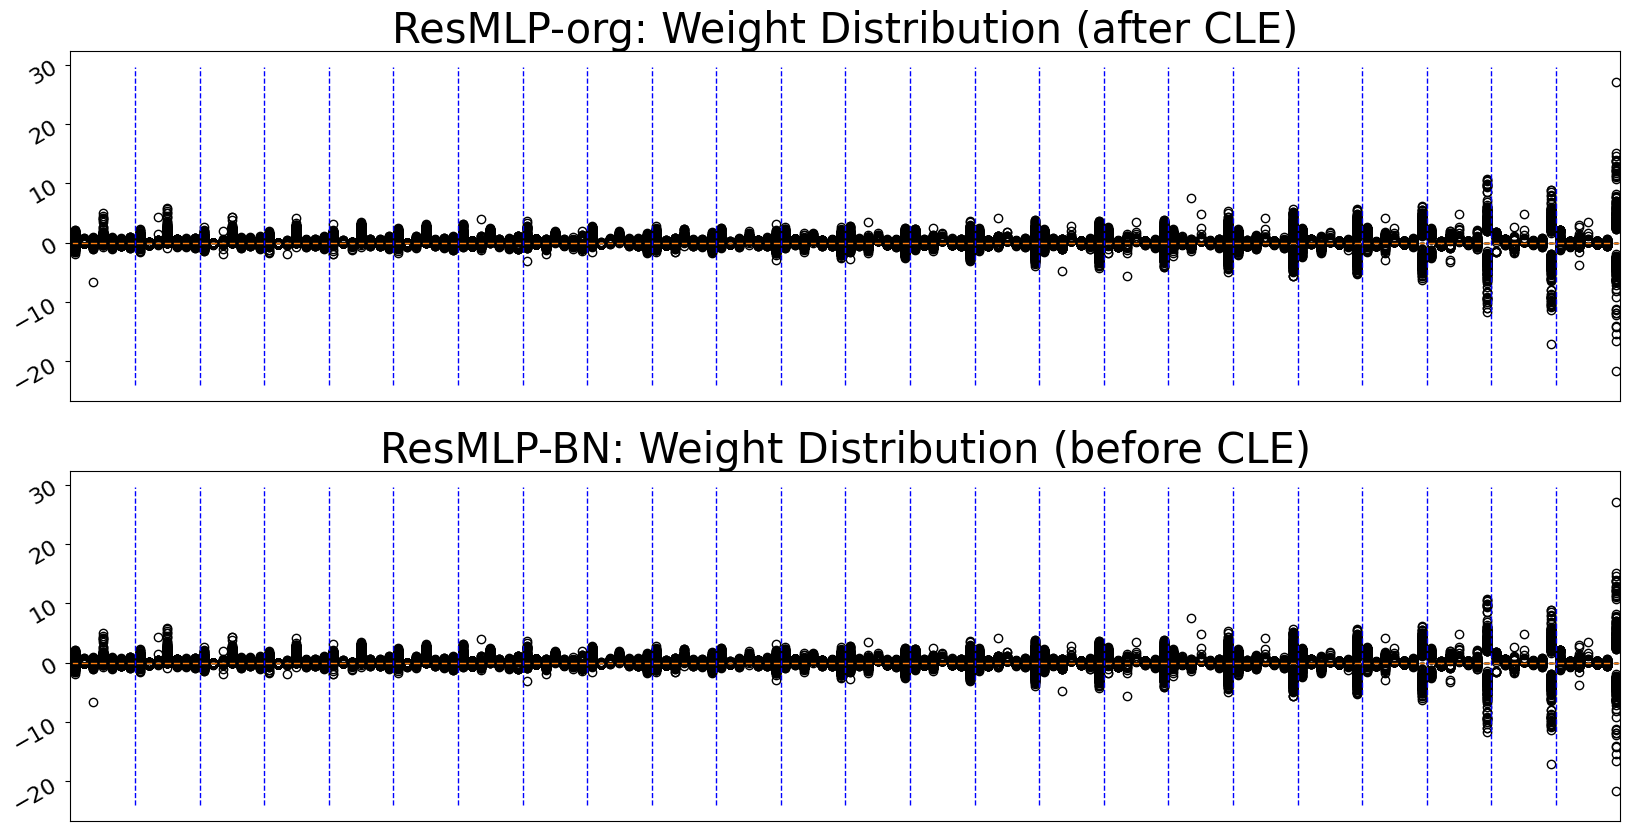

In [74]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
layer_dist(model, 0, 23, name="ResMLP-org: Weight Distribution (after CLE)", ax=ax[0])
# cle_for_resmlp(model)
# res_
# cle_for_resmlp(model_norm)
layer_dist(model, 0, 23, name="ResMLP-BN: Weight Distribution (before CLE)", ax=ax[1])

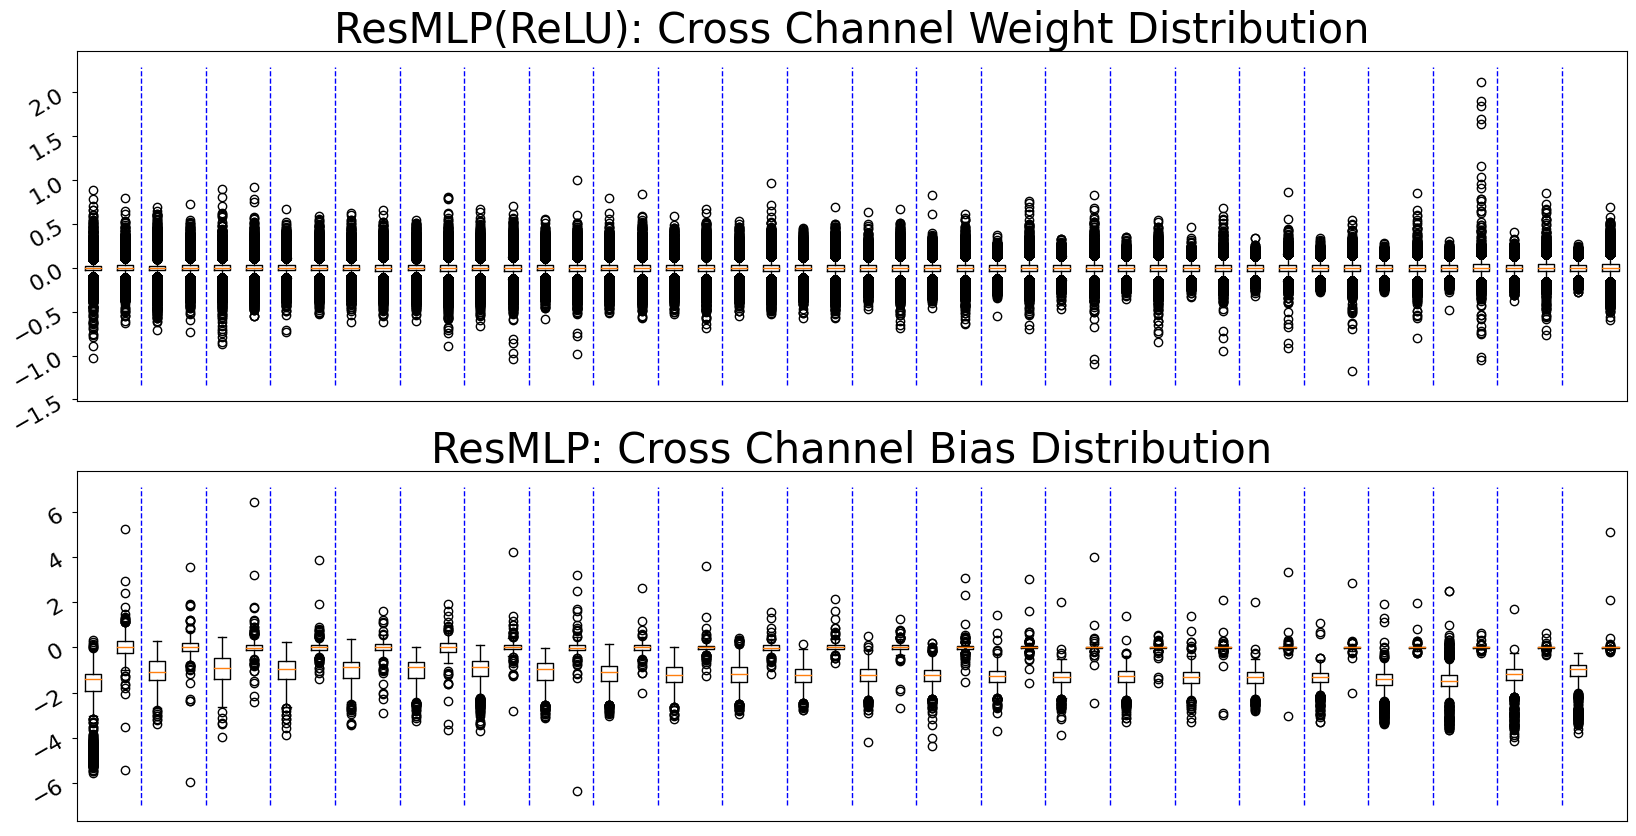

In [75]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model = resmlp_24(pretrained=False).eval()
model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
layer_dist(model, 0, 23, name="ResMLP(ReLU): Cross Channel Weight Distribution", show_layers=["mlp.fc1", "mlp.fc2"], type="weight", ax=ax[0])
# cle_for_resmlp(model)
# res_
# cle_for_resmlp(model_norm)
layer_dist(model, 0, 23, name="ResMLP: Cross Channel Bias Distribution", show_layers=["mlp.fc1", "mlp.fc2"], type="bias", ax=ax[1])

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.948 ( 9.948)
Calibrate: [10/21]	Time  2.185 ( 3.163)
Calibrate: [20/21]	Time  0.400 ( 2.696)
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  8.898 ( 8.898)
Calibrate: [10/21]	Time  1.818 ( 2.484)
Calibrate: [20/21]	Time  0.268 ( 2.080)


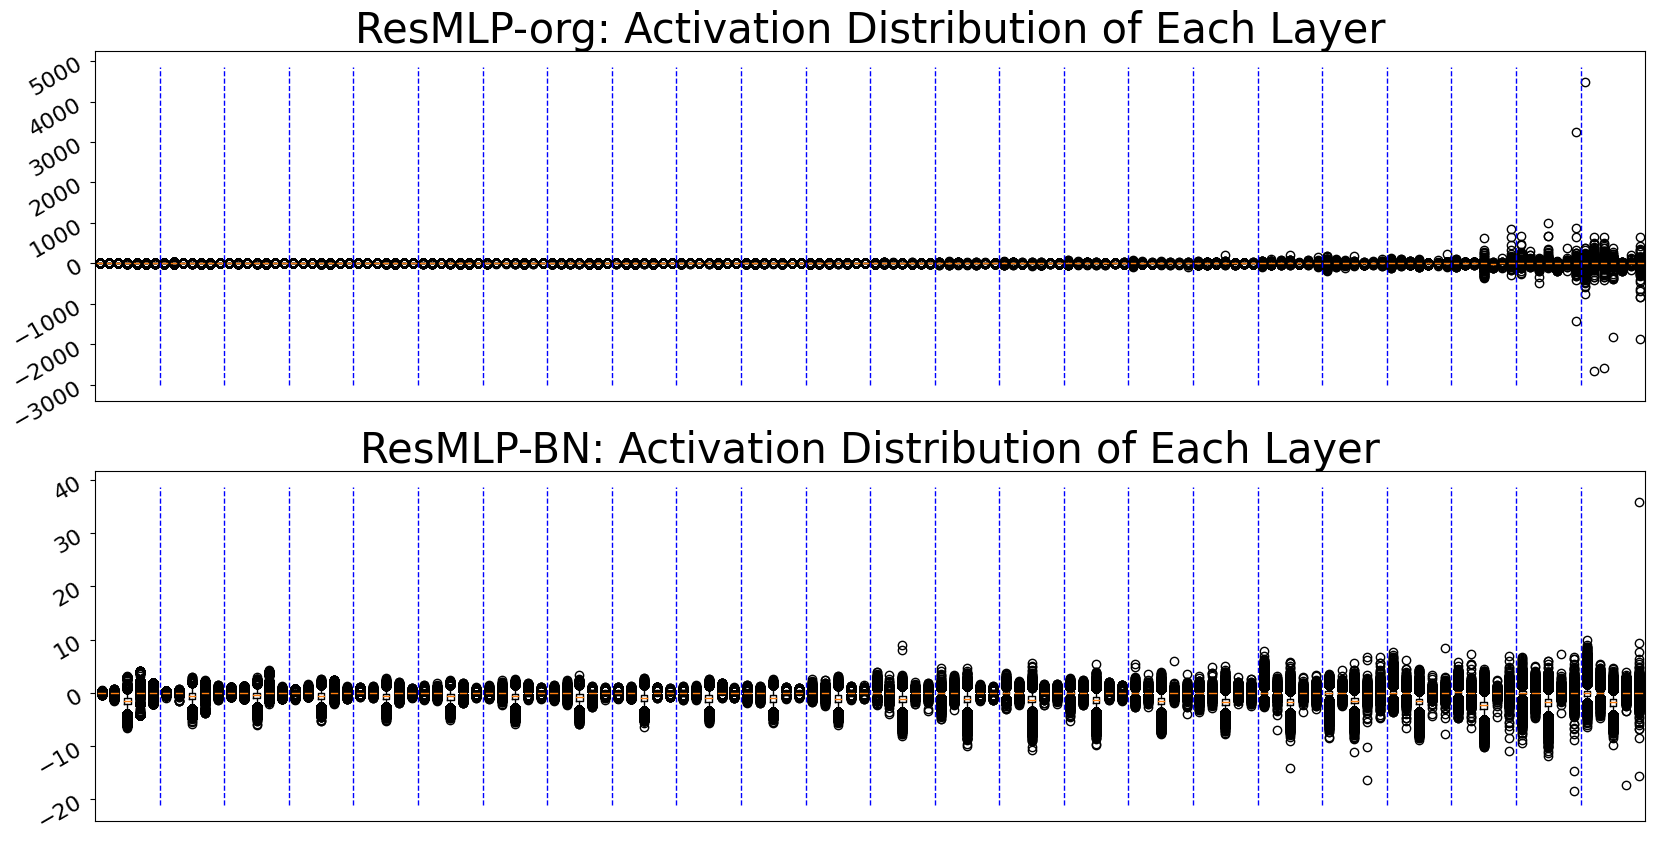

In [76]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

model.cuda()
model_norm.cuda()
act_dist(model, 0, 23, name='ResMLP-org: Activation Distribution of Each Layer', ax=ax[0], real_sim=True)
act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1], real_sim=True)

In [ ]:
# model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# model.cuda()
# model_norm.cuda()
model.cpu()
model_norm.cpu()
labels, data = scale_plot(model, 0, 23, show_layers=["gamma_1", "gamma_2"], name='Scale of gamma_1, gamma_2', ax=ax[0])
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(labels, data)
add_value_labels(ax[0], skip_cnt=1, precision=2)

labels, data = scale_plot(model_norm, 0, 23, show_layers=["gamma_1", "gamma_2"], name='Scale of gamma_1, gamma_2', ax=ax[1])
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(labels, data)
add_value_labels(ax[1], skip_cnt=1, precision=2)



In [ ]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[0])

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer (without attn)', show_layers=["mlp.fc1", "mlp.fc2"], ax=ax[1])

In [8]:
model_norm.asda

AttributeError: 'resmlp_models' object has no attribute 'asda'

In [ ]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='Activation Distribution of Each Layer', ax=ax[0])

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1])

In [ ]:
# ckp = torch.load("./resmlp_norm2.pth", map_location='cpu')["model"]
# modified_dict = {}
# for k, v in ckp.items():
#     # if "norm" in k:
#     #     # print(k)
#     #     if ("weight" in k) or ("bias" in k):
#     #         continue
#     modified_dict[k] = v

# _ = model_norm.load_state_dict(ckp, strict=False)

checkpoint = torch.load("./resmlp_norm2.pth", map_location='cpu')["model"]
_ = model_norm.load_state_dict(checkpoint, strict=False)

In [ ]:
model_norm = resmlp_24_norm(pretrained=True).eval()

In [ ]:
import torchsummary as summary
summary.summary(model, (3, 224, 224), device="cuda")

In [ ]:
import torchsummary as summary
summary.summary(model_norm, (3, 224, 224), device="cuda")

In [ ]:
model = resmlp_24(pretrained=True).cuda().eval()
model_norm = resmlp_24_norm(pretrained=True).cuda().eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='ResMLP-org: Activation Distribution of Each Layer', ax=ax[0], real_sim=False)
act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1], real_sim=False)

In [ ]:
CHECKPOINT_PATH = "input8-conv-res16-act8.pth.tar"

model = resmlp_24()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])

for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        print(n)

In [ ]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add_1.observer" in n:
        label_1.append(n)
        data_1.append([m.scale.item()])

ax[0].set_title('Rescale After add_1 (fp)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=2, precision=4)

label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add_2.observer" in n:
        label_2.append(n)
        data_2.append(m.scale.item())

ax[1].set_title('Rescale After add_2 (fp)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=4)

In [ ]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add" in n and "observer" not in n:
        label_1.append(n)
        scale = (m.res_mult[0].type(torch.double) / (2.0 ** m.res_shift[0]).type(torch.double)).type(torch.float)
        data_1.append(scale)

ax[0].set_title('Alignment for Residual Layer (int16 -> int32)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=1, precision=2)


label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add" in n and "observer" not in n:
        label_2.append(n)
        scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
        data_2.append(scale)

ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=2)

In [ ]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        label_1.append(n)
        data_1.append(m.observer.scale.item())

ax[0].set_title('Scales for Weights Layers (fp -> int8)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=9, precision=3)


# label_2 = []
# data_2 = []
# for n, m in qmodel.named_modules():
#     if "add" in n and "observer" not in n:
#         label_2.append(n)
#         scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
#         data_2.append(scale)

# ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
# ax[1].tick_params(labelrotation=30)
# for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
#     label.set_fontsize(16)
# ax[1].plot(label_2, data_2)
# add_value_labels(ax[1], skip_cnt=2, precision=2)

### Weight Scale Test

In [51]:
from torchsummary import summary
summary(org_model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
            Linear-4             [-1, 196, 384]         147,840
            Linear-5             [-1, 384, 196]          38,612
            Linear-6             [-1, 196, 384]         147,456
          Identity-7             [-1, 196, 384]               0
          Identity-8             [-1, 196, 384]               0
            Linear-9             [-1, 196, 384]         147,840
           Linear-10            [-1, 196, 1536]         591,360
             ReLU-11            [-1, 196, 1536]               0
          Dropout-12            [-1, 196, 1536]               0
           Linear-13             [-1, 196, 384]         590,208
          Dropout-14             [-1, 1

In [62]:
org_model = resmlp_24(pretrained=False).eval()
org_model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))

model = resmlp_24(pretrained=False).eval()
model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
print(same_output(model, org_model, eps=1e-5))

True


In [63]:
a = 0.1

# model.blocks[1].mlp.fc1
model.blocks[1].mlp.fc1.weight.data.div_(a)
model.blocks[1].mlp.fc1.bias.data.div_(a)

model.blocks[1].mlp.fc2.weight.data.mul_(a)
# model.blocks[1].mlp.fc2.bias.data.mul_(a)

print(same_output(model, org_model, eps=1e-5))


True


In [56]:
w1 = model.blocks[1].mlp.fc1.weight.data
b1 = model.blocks[1].mlp.fc1.bias.data

w2 = model.blocks[1].mlp.fc2.weight.data
b2 = model.blocks[1].mlp.fc2.bias.data

In [60]:
import numpy as np

a = 1.2
x = torch.Tensor(np.random.rand(1536, 384)).unsqueeze(0)


x1 = F.linear(x*a, w1, b1)
print(x1[0][:10])

x1 = F.linear(x, w1, b1)*a
print(x1[0][:10])

tensor([[-20.7404,  -2.5549,  -7.4371,  ..., -15.9541,  -3.1765,  -3.6960],
        [-18.0102,  -5.2776,  -1.1875,  ..., -13.5424,  -3.7982,  -0.7812],
        [-16.0846,  -9.3105,  -4.4374,  ..., -13.6630,  -3.8831,  -2.9441],
        ...,
        [-17.2234,  -5.9473,  -0.4635,  ..., -12.4889,  -3.7520,  -3.7264],
        [-14.5020,  -8.5389, -11.5101,  ..., -13.0452,  -8.7345,   1.0665],
        [-19.9096,  -2.7747,  -5.8956,  ..., -17.7346,  -7.4741,  -6.7266]])
tensor([[-23.6173,  -3.7837, -10.2398,  ..., -18.2323,  -5.5340,  -4.6883],
        [-20.8871,  -6.5064,  -3.9902,  ..., -15.8206,  -6.1558,  -1.7735],
        [-18.9615, -10.5392,  -7.2401,  ..., -15.9411,  -6.2406,  -3.9364],
        ...,
        [-20.1004,  -7.1760,  -3.2662,  ..., -14.7671,  -6.1095,  -4.7187],
        [-17.3789,  -9.7677, -14.3127,  ..., -15.3234, -11.0920,   0.0742],
        [-22.7866,  -4.0035,  -8.6983,  ..., -20.0128,  -9.8317,  -7.7189]])


In [58]:
import numpy as np

a = 1.2
x = torch.Tensor(np.random.rand(1536, 384)).unsqueeze(0)


x1 = F.linear(x, w1*a, b1*a)
x2 = F.linear(x1, w2/a, b2/a)
print(x2[0][:10])

x1 = F.linear(x, w1, b1)
x2 = F.linear(x1, w2, b2)
print(x2[0][:10])

tensor([[ 1.4595, -0.2216, -2.6724,  ...,  2.6562, -0.1907,  3.1663],
        [-0.0743, -0.0985, -2.1127,  ...,  2.0094,  0.0330,  4.0484],
        [ 1.4549,  1.5411, -1.9220,  ...,  2.1522, -0.9108,  2.8985],
        ...,
        [ 0.8074,  0.1950, -2.2156,  ...,  1.2923, -0.3952,  2.4369],
        [ 2.4564,  0.3205, -2.5354,  ...,  1.0211, -0.4349,  2.8428],
        [ 1.9312,  0.6765, -3.9492,  ...,  2.0036,  0.7957,  3.1072]])
tensor([[ 1.4586, -0.2188, -2.6746,  ...,  2.6533, -0.1922,  3.1631],
        [-0.0752, -0.0957, -2.1148,  ...,  2.0065,  0.0315,  4.0452],
        [ 1.4540,  1.5439, -1.9241,  ...,  2.1492, -0.9123,  2.8953],
        ...,
        [ 0.8065,  0.1978, -2.2178,  ...,  1.2893, -0.3967,  2.4337],
        [ 2.4556,  0.3233, -2.5376,  ...,  1.0181, -0.4364,  2.8395],
        [ 1.9304,  0.6794, -3.9514,  ...,  2.0007,  0.7942,  3.1039]])
